# To Grant or Not to Grant: Deciding on Compensation Benefits 

### Machine Learning Group Project 2024/2025 - Group 52


__Members:__
- Diogo Rodrigues _(20240512@novaims.unl.pt)_
- Alexandre Gonçalves _(20240738@novaims.unl.pt)_
- Pedro Costa _(20222121@novaims.unl.pt)_
- Santiago Taylor _(20240542@novaims.unl.pt)_
- Lena Hermann _(20241446@novaims.unl.pt)_

## Introduction
- __Motivation__: x
- __Dataset__: The dataset represents x
- __Task and Goal__: The purpose of this notebook is to create and evaluate several classification models for accurately predicting the WCB’s final decision on what type of injury should be given to a claim.

## Table of Content
<a id='top'></a>
[1. Set-Up and Data Loading](#dataload) <br>
[2. Data Understanding and Exploration](#dataunderstand) <br>
[3. Data Cleaning and Pre-processing](#dataclean) <br>
[4. Feature Selection](#features) <br>
[5. Modeling and Evaluation](#modeling) <br>

## 1. Set-Up and Data Loading <a id='dataload'></a>
[to the top](#top)

### 1.1 Import the needed libraries

In [4]:
import numpy as np #to efficiently compute functions
import pandas as pd #to work with data frames
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import zipfile #to open zipfile
pd.set_option('display.max_columns', 35) #to display 35 columns
pd.set_option('display.max_rows', 100) #to display 100 rows
from ydata_profiling import ProfileReport
import os

# data partition
from sklearn.model_selection import train_test_split

#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

# embedded methods
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

### 1.2 Read the data and first overview

In [5]:
train_zip_path = 'train_data.csv.zip'
test_zip_path = 'test_data.csv.zip'

# open csv file from zip
def read_zipped_csv(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        csv_filename = z.namelist()[0]
        
        with z.open(csv_filename) as f:
            return pd.read_csv(f)

train_df = read_zipped_csv(train_zip_path)
test_df = read_zipped_csv(test_zip_path)
""" 
print("Train Data:")
print(train_df.head())
print("Test Data:")
print(test_df.head())  """

' \nprint("Train Data:")\nprint(train_df.head())\nprint("Test Data:")\nprint(test_df.head())  '

## 2. Data Understanding and Exploration <a id='dataunderstand'></a>
[to the top](#top)

__Target Variable__

We just have a look at the distribution of the target variable 'Claim Injury Type'. To check how our dataset is balanced.

In [6]:
# Target variable statistics
train_df['Claim Injury Type'].describe()

count          574026
unique              8
top       2. NON-COMP
freq           291078
Name: Claim Injury Type, dtype: object

In [7]:
train_df.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


Building a PMF distribution

In [8]:
copy_train_df = train_df.copy()

copy_train_df['Claim Injury Type'].fillna('Missing', inplace=True)


In [9]:
# Get the counts for each category

counts = copy_train_df['Claim Injury Type'].value_counts().sort_index()

print(counts)

Claim Injury Type
1. CANCELLED        12477
2. NON-COMP        291078
3. MED ONLY         68906
4. TEMPORARY       148507
5. PPD SCH LOSS     48280
6. PPD NSL           4211
7. PTD                 97
8. DEATH              470
Missing             19445
Name: count, dtype: int64


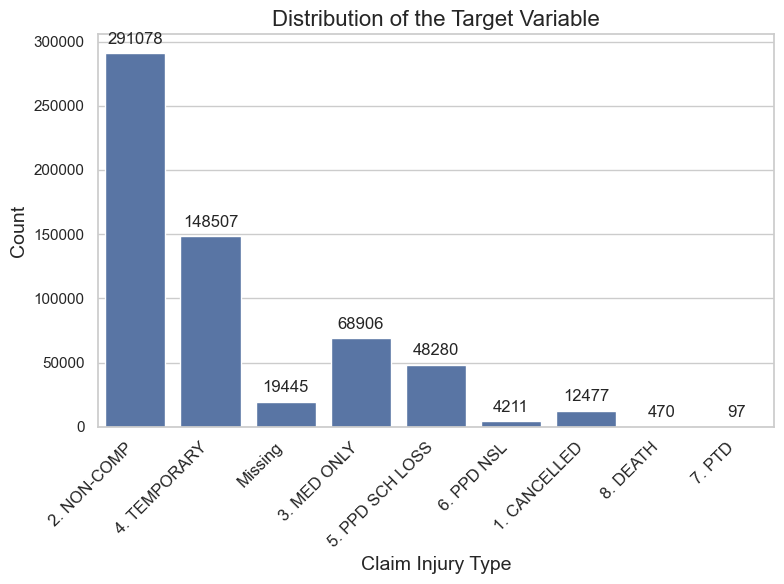

In [10]:
# Check the distribution of the target variable

# Adjust figure size and font
plt.figure(figsize=(8, 6))  # Increase figure size
ax = sns.countplot(x='Claim Injury Type', data=copy_train_df)  # Replace 'Claim Injury Type' with your actual column name

# Rotate x-axis labels, adjust font size, and wrap text if needed
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=12)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set title and axis labels with increased font size
plt.title("Distribution of the Target Variable", fontsize=16)
plt.xlabel("Claim Injury Type", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tight_layout()  # Ensure everything fits within the figure area
plt.show()


Examine Missing Values

In [11]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

missing_values = missing_values_table(copy_train_df)

Your selected dataframe has 33 columns.
There are 30 columns that have missing values.


In [12]:
missing_values.head(30)

,Missing Values,% of Total Values
OIICS Nature of Injury Description,593471,100.0
IME-4 Count,460668,77.6
First Hearing Date,442673,74.6
C-3 Date,406226,68.4
Birth Year,48523,8.2
Average Weekly Wage,48096,8.1
Zip Code,48082,8.1
WCIO Part Of Body Description,36527,6.2
WCIO Part Of Body Code,36527,6.2
WCIO Nature of Injury Description,35102,5.9


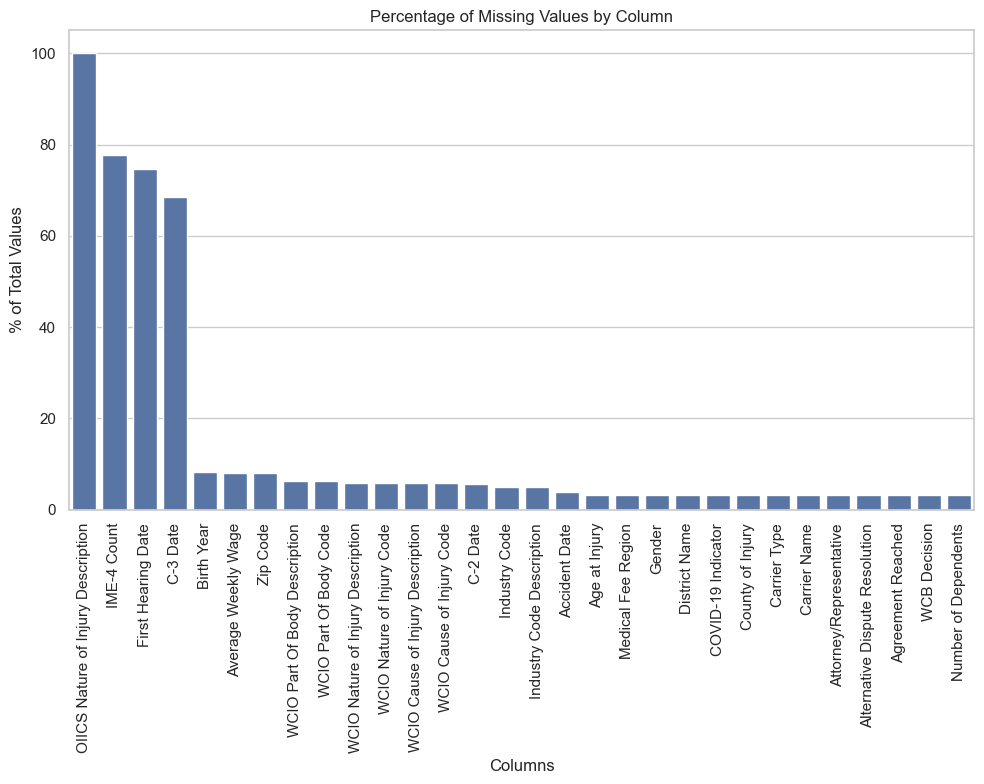

In [13]:
# Assuming mis_val_table_ren_columns is your resulting table
def plot_missing_values(mis_val_table):
    plt.figure(figsize=(10, 8))
    
    # Create a bar plot for the percentage of missing values
    sns.barplot(x=mis_val_table.index, 
                y=mis_val_table['% of Total Values'])
    
    # Rotate the x labels for better readability
    plt.xticks(rotation=90)
    
    # Set plot labels and title
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Columns')
    plt.ylabel('% of Total Values')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the missing values
plot_missing_values(missing_values)

### Numerical and categorical features split

In [15]:
# Separate from X_copy numerical and categorical columns
numerical_cols = copy_train_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = copy_train_df.select_dtypes('object').columns.tolist()

categorical_cols.remove('Claim Injury Type')

target = copy_train_df['Claim Injury Type']

print(numerical_cols, "\n", categorical_cols)

['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents'] 
 ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']


#### Alex Features Analysis (Accident Date -> District Name)

In [16]:
alex_numerical = ['Age at Injury','Average Weekly Wage','Birth Year','Claim Identifier']
alex_categorical = ['Accident Date','Alternative Dispute Resolution','Assembly Date','Attorney/Representative','C-2 Date','C-3 Date','Carrier Name','Carrier Type','County of Injury','COVID-19 Indicator','District Name']

In [17]:
# Create a subset of categorical features that doesnt include dates
subset_alex_categorical = ['Alternative Dispute Resolution','Attorney/Representative','Carrier Name','Carrier Type','County of Injury','COVID-19 Indicator','District Name']

### Anomalies detection on numerical features

In [18]:
def numerical_describe(df, alex_numerical):
    # Check if the column in the DataFrame is numerical
    if np.issubdtype(df[alex_numerical].dtype, np.number):
        return df[alex_numerical].describe()
    else:
        return None

# Iterate over the list of numerical columns
for col in alex_numerical:
    print(f"Description for column {col}:\n")
    
    print(numerical_describe(copy_train_df, col))



Description for column Age at Injury:

count    574026.000000
mean         42.114270
std          14.256432
min           0.000000
25%          31.000000
50%          42.000000
75%          54.000000
max         117.000000
Name: Age at Injury, dtype: float64
Description for column Average Weekly Wage:

count    5.453750e+05
mean     4.910883e+02
std      6.092918e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.410000e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64
Description for column Birth Year:

count    544948.000000
mean       1886.767604
std         414.644423
min           0.000000
25%        1965.000000
50%        1977.000000
75%        1989.000000
max        2018.000000
Name: Birth Year, dtype: float64
Description for column Claim Identifier:

count    5.934710e+05
mean     2.366760e+07
std      1.079271e+08
min      5.393066e+06
25%      5.593414e+06
50%      5.791212e+06
75%      5.991000e+06
max      9.998917e+08
Name: C

* Age at injury analysis


Text(0.5, 0, 'Age at Injury')

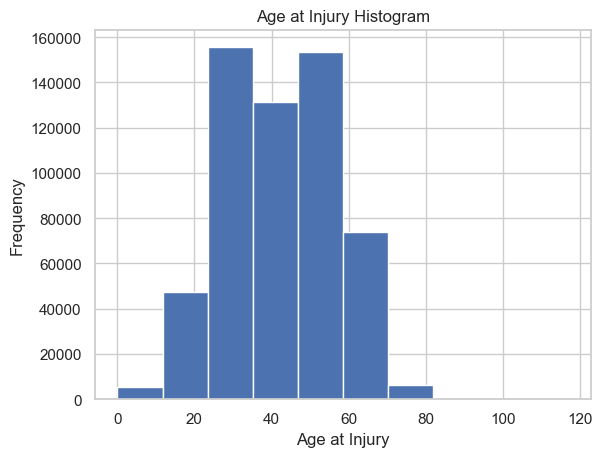

In [19]:
# Age at injury has a max value of 117, which is likely an error

copy_train_df['Age at Injury'].plot.hist(title = 'Age at Injury Histogram')
plt.xlabel('Age at Injury')

In [20]:
# Anomalous ages: 117 or under 14 (minimum legal working age in the US)
anom_age = copy_train_df[(copy_train_df['Age at Injury'] > 95) | (copy_train_df['Age at Injury'] < 14)]
non_anom_age = copy_train_df[(copy_train_df['Age at Injury'] < 95) & (copy_train_df['Age at Injury'] >= 14)]

print(f'There are {len(anom_age)} persons with anomalous age of injury.')

# Create an anomalous age flag column: True if age is anomalous, otherwise False
copy_train_df['ANOM_AGE'] = (copy_train_df['Age at Injury'] > 117) | (copy_train_df['Age at Injury'] < 14)


There are 5635 persons with anomalous age of injury.


Text(-0.3100000000000023, 0.5, 'Boxplot')

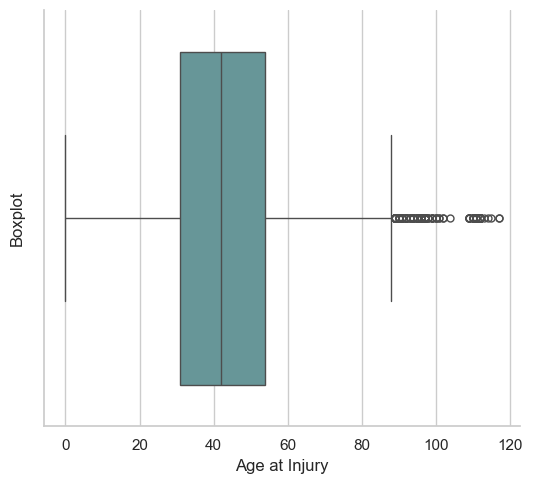

In [21]:
sns.catplot(data=copy_train_df, kind='box', x='Age at Injury', color='cadetblue')
plt.xlabel('Age at Injury')
plt.ylabel('Boxplot')

# Outliers after 85 years old -> What to do with them?


In [22]:
# Check NaN values in Age at Injury

copy_train_df["Age at Injury"].isna().sum()

19445

In [23]:
# Check Null values in Age at Injury

copy_train_df["Age at Injury"].isnull().sum()

# We have 19445 missing values in Age at Injury

19445

In [24]:
# Group Age at Injury into bins

# Define age bins and labels
age_bins = [0, 19, 29, 39, 49, 59, float('inf')]
age_labels = ['Under 20', '20-29', '30-39', '40-49', '50-59', '60 and above']

# Create the age groups
copy_train_df['Age_Group'] = pd.cut(copy_train_df['Age at Injury'], bins=age_bins, labels=age_labels)

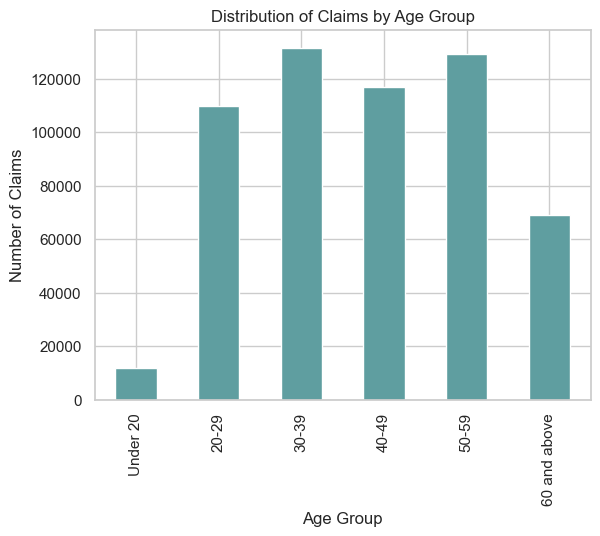

In [25]:
# Plot age group distribution
copy_train_df['Age_Group'].value_counts().sort_index().plot(kind='bar', color='cadetblue')
plt.xlabel("Age Group")
plt.ylabel("Number of Claims")
plt.title("Distribution of Claims by Age Group")
plt.show()

In [26]:
# Check the distribution of the target variable by age group
target_distribution_by_age = pd.crosstab(copy_train_df['Age_Group'], train_df['Claim Injury Type'] , normalize='index')


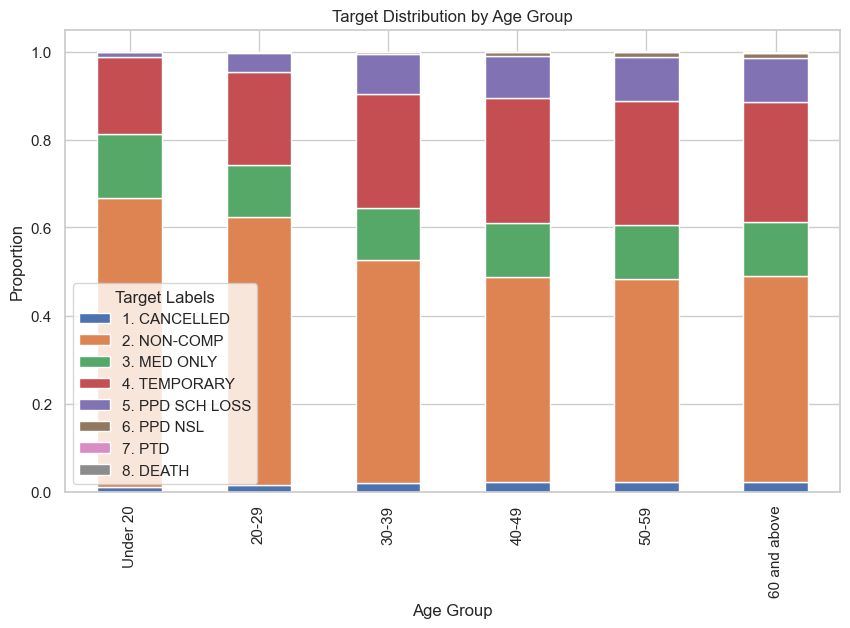

In [27]:
# Stacked bar plot of target distribution by age group
target_distribution_by_age.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel("Age Group")
plt.ylabel("Proportion")
plt.title("Target Distribution by Age Group")
plt.legend(title="Target Labels")
plt.show()

The analysis of claim injury types across age groups reveals distinct patterns. Younger age groups (Under 20, 20-29) have a higher proportion of temporary claims, while older age groups (50-59 and 60 and above) show increased proportions of more severe injury types, including Permanent Partial Disability (PPD) and Permanent Total Disability (PTD).

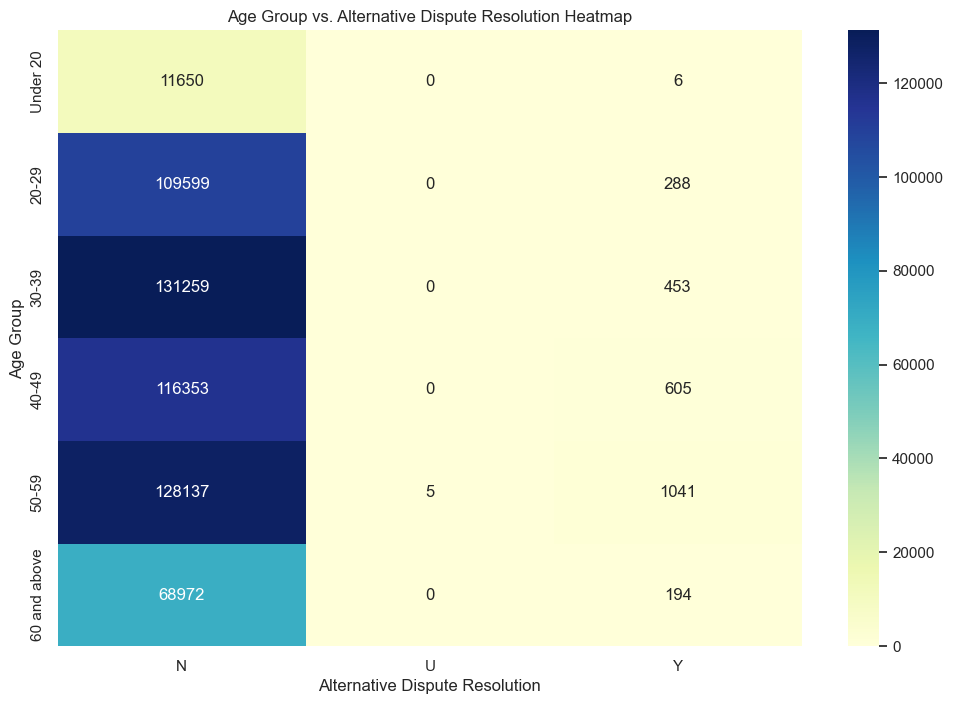

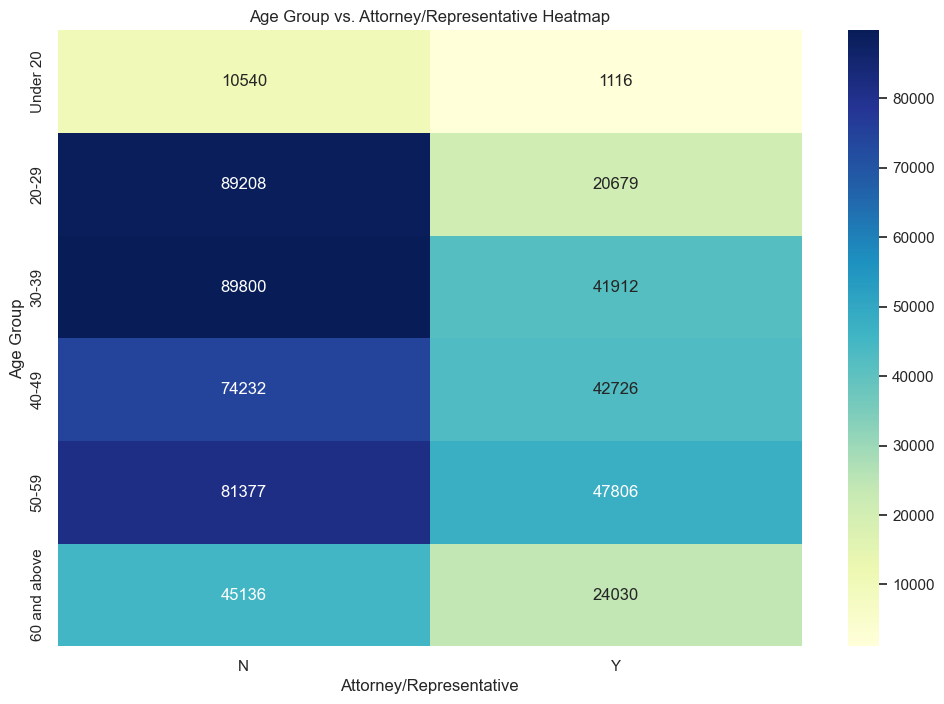

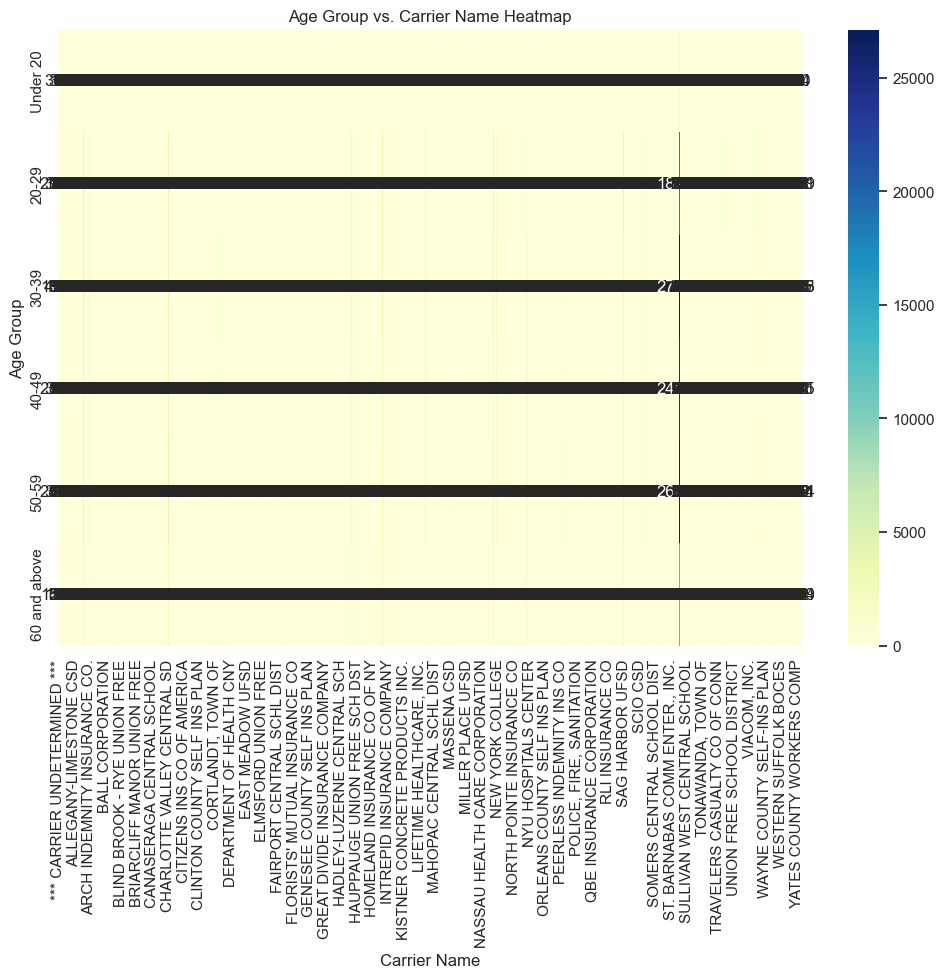

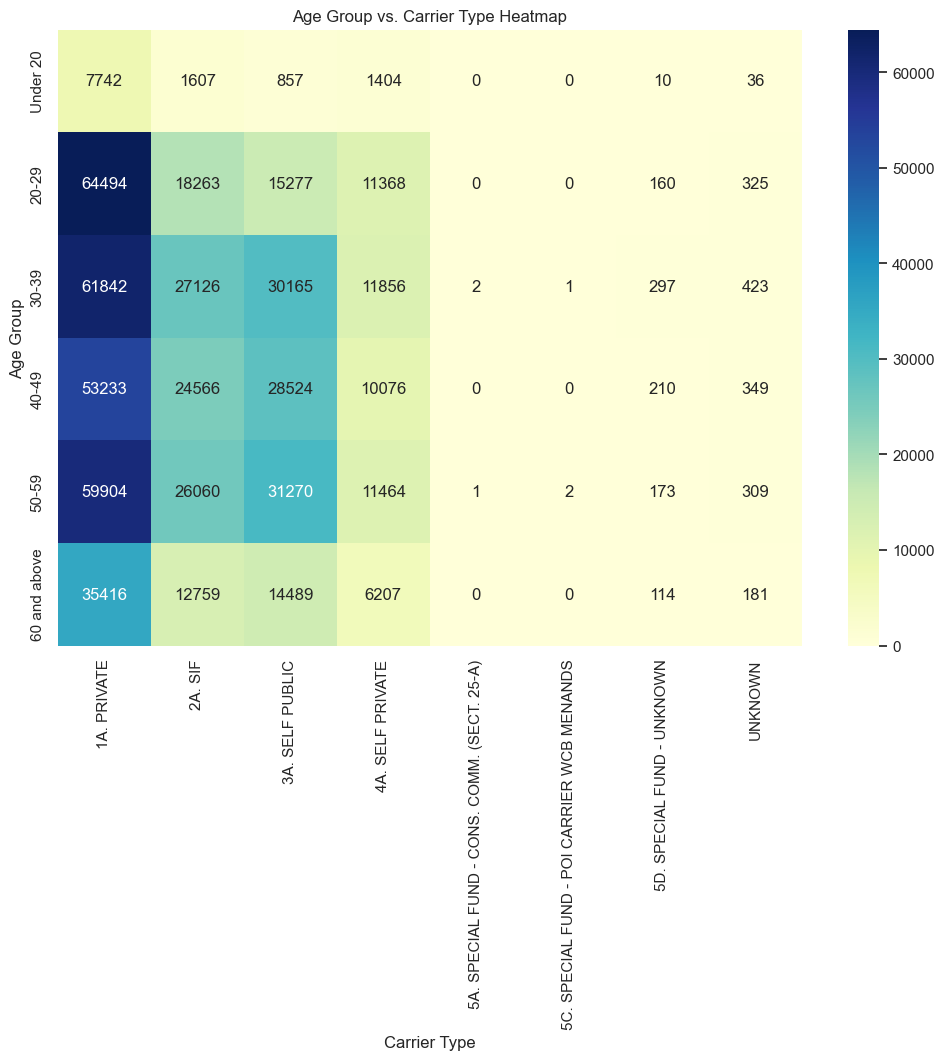

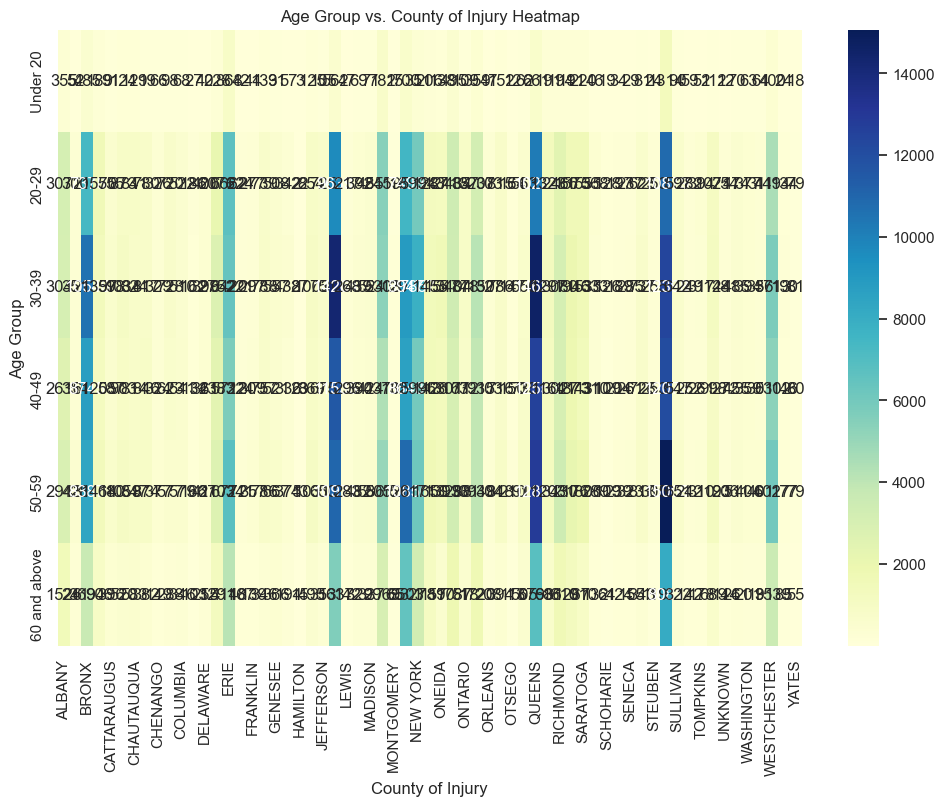

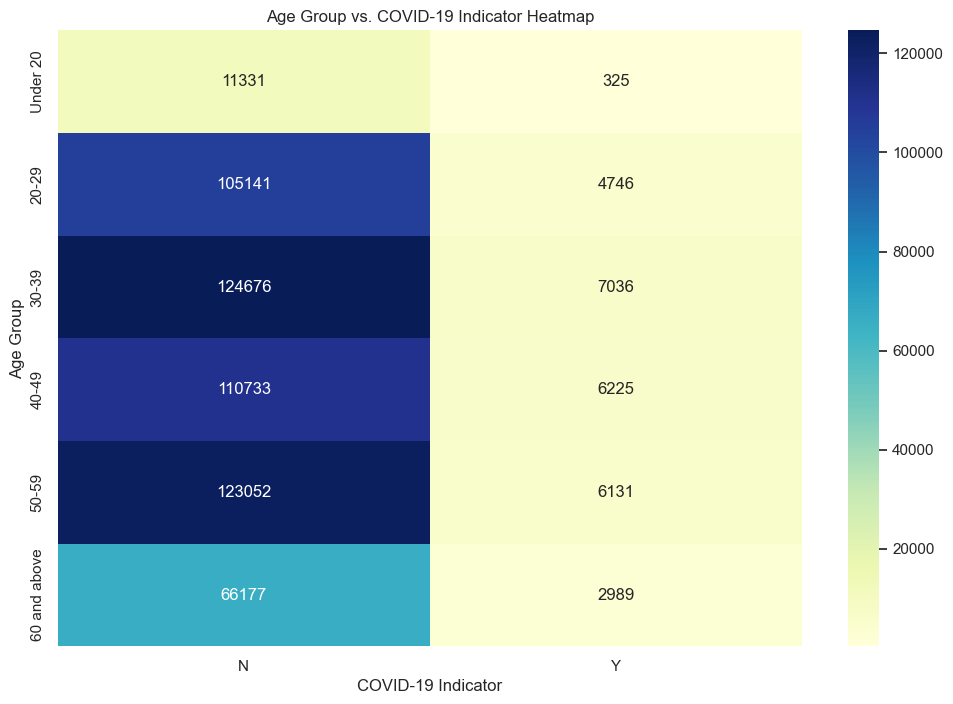

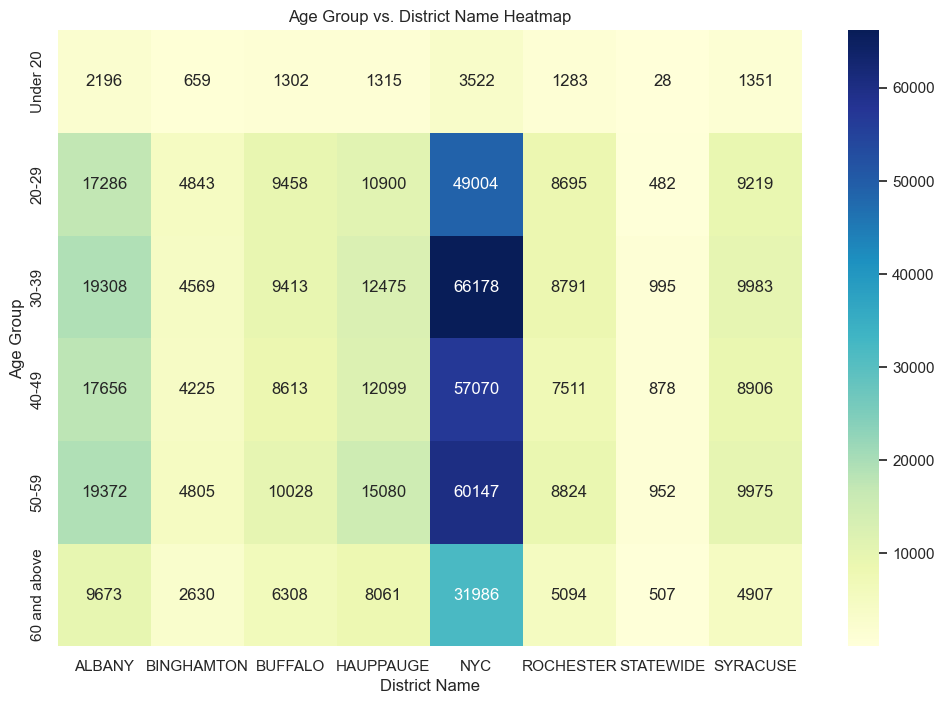

In [28]:
for feature in subset_alex_categorical:
    # Create crosstab between 'Age_Group' and the current categorical feature
    age_feature_crosstab = pd.crosstab(copy_train_df['Age_Group'], copy_train_df[feature])
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(age_feature_crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel(feature)
    plt.ylabel("Age Group")
    plt.title(f"Age Group vs. {feature} Heatmap")
    plt.show()

* Average weekly wage analysis

Text(0.5, 0, 'Average Weekly Wage')

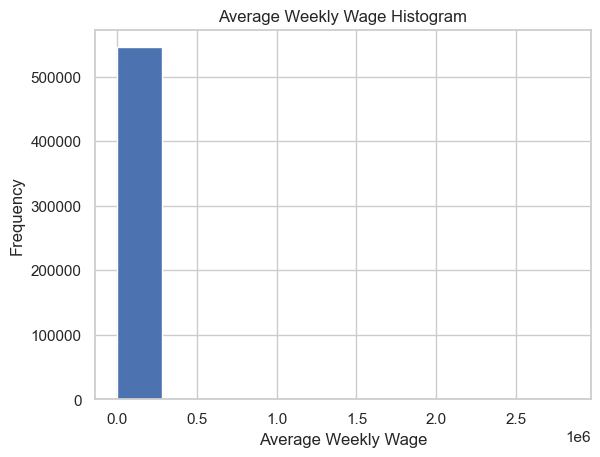

In [29]:
# Age at injury has a max value of 117, which is likely an error

copy_train_df['Average Weekly Wage'].plot.hist(title = 'Average Weekly Wage Histogram')
plt.xlabel('Average Weekly Wage')

Text(0.5, 0, 'Average Weekly Wage')

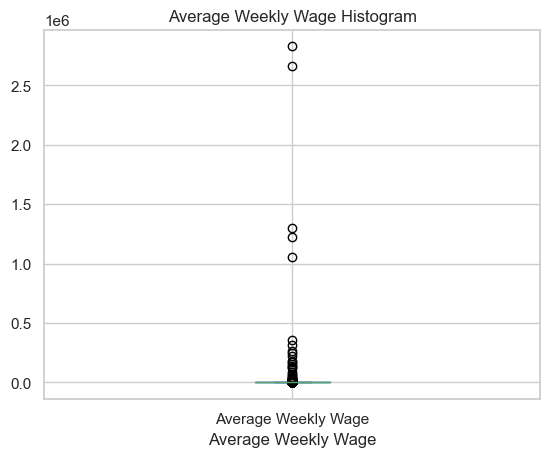

In [30]:
copy_train_df['Average Weekly Wage'].plot.box(title = 'Average Weekly Wage Histogram')
plt.xlabel('Average Weekly Wage')

There are a lot of outliers, and the IQR is thin , so perhaps we should do some outliers handling here.

In [81]:
copy_train_df['Average Weekly Wage'].describe() # We can see that 50% of the values are 0 which is weird

count    5.563640e+05
mean     4.786446e+02
std      6.032600e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.158225e+02
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64

In [31]:
len(copy_train_df[copy_train_df['Average Weekly Wage'] == 0]) / len(copy_train_df)

# 62 % of values from average weekly wage are 0

0.5652340215444394

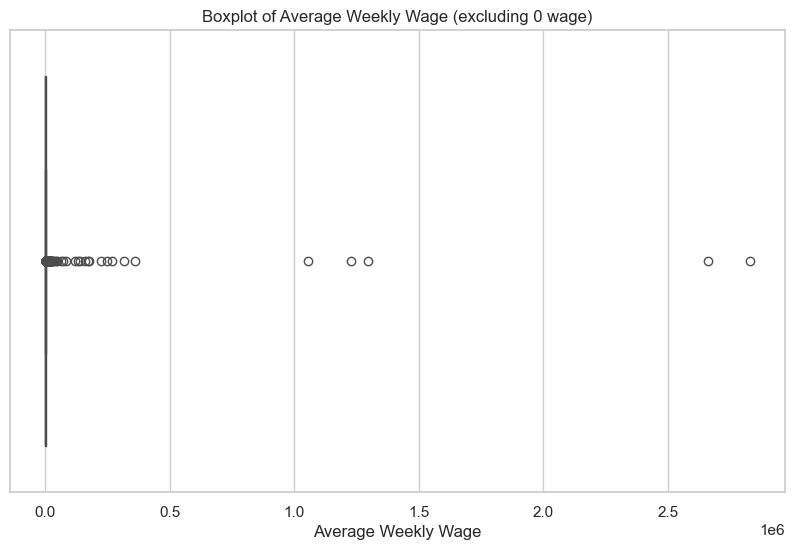

In [33]:
# Filter out the rows with 0 wage and store them in a variable
zero_wage_df = copy_train_df[copy_train_df['Average Weekly Wage'] == 0]

# Create a new DataFrame excluding those rows
non_zero_wage_df = copy_train_df[copy_train_df['Average Weekly Wage'] != 0]

# Step 3: Perform the boxplot analysis on the new DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=non_zero_wage_df, x='Average Weekly Wage')
plt.title('Boxplot of Average Weekly Wage (excluding 0 wage)')
plt.show()


In [95]:
non_zero_wage_df['Average Weekly Wage'].describe()

count    2.089220e+05
mean     1.274641e+03
std      9.792808e+03
min      1.394000e+01
25%      7.000000e+02
50%      1.067730e+03
75%      1.575720e+03
max      2.828079e+06
Name: Average Weekly Wage, dtype: float64

Text(0, 0.5, 'Count of observations')

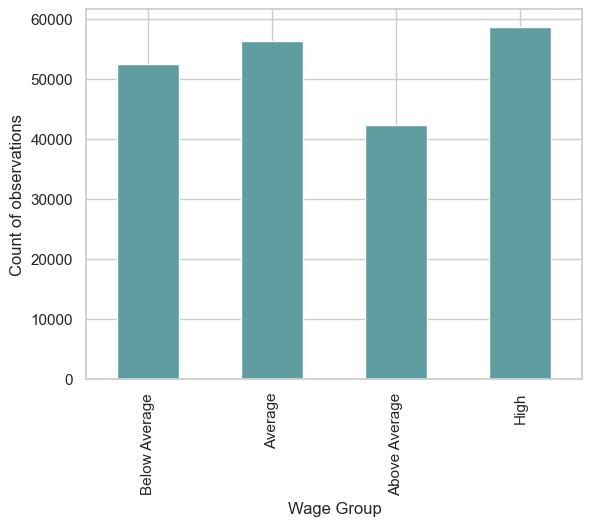

In [38]:
# Group Average Weekly Wage into bins (Based on the boxplot)

# Define wage bins and labels
wage_bins = [0, 700, 1100, 1500, max(non_zero_wage_df['Average Weekly Wage'])]

wage_labels = ['Below Average', 'Average', 'Above Average', 'High']

# Create the wage groups

non_zero_wage_df['Wage_Group'] = pd.cut(non_zero_wage_df['Average Weekly Wage'], bins=wage_bins, labels=wage_labels)

# Plot wage group distribution
non_zero_wage_df['Wage_Group'].value_counts().sort_index().plot(kind='bar', color='cadetblue')
plt.xlabel("Wage Group")
plt.ylabel("Count of observations")



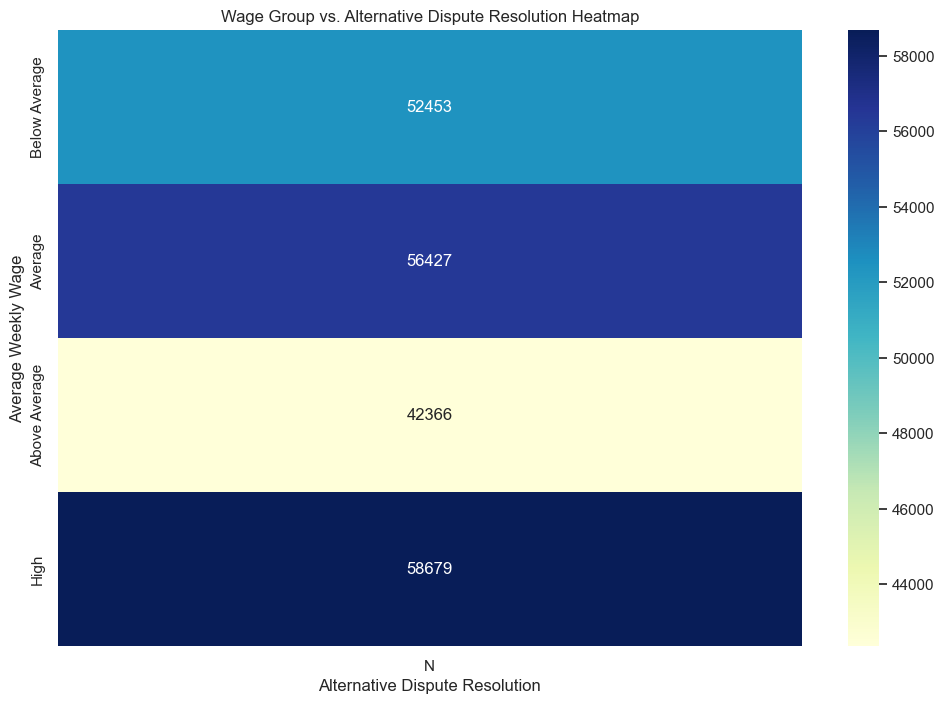

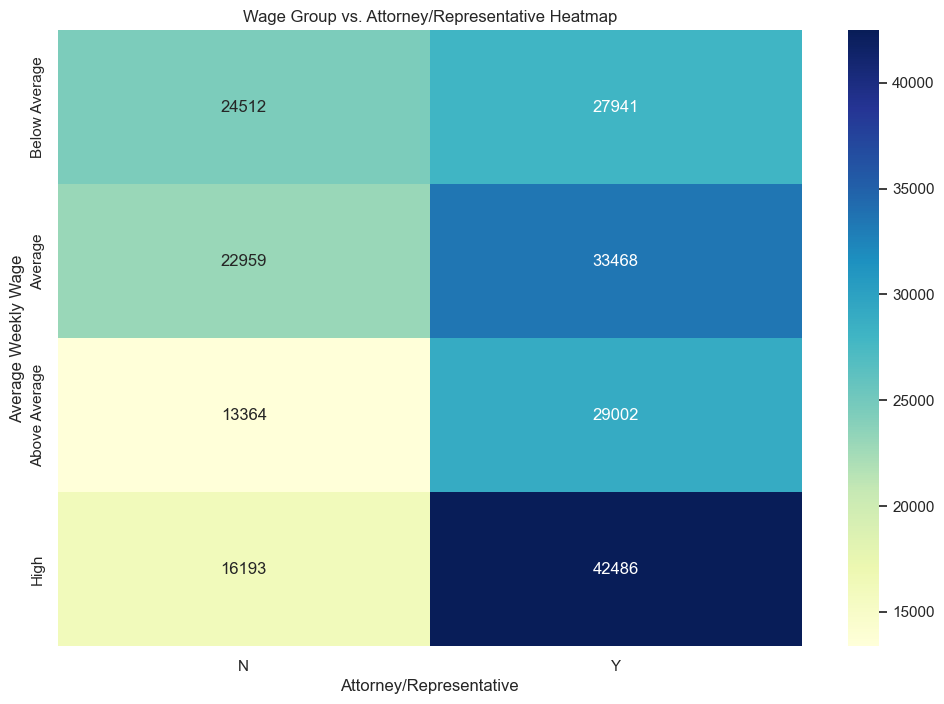

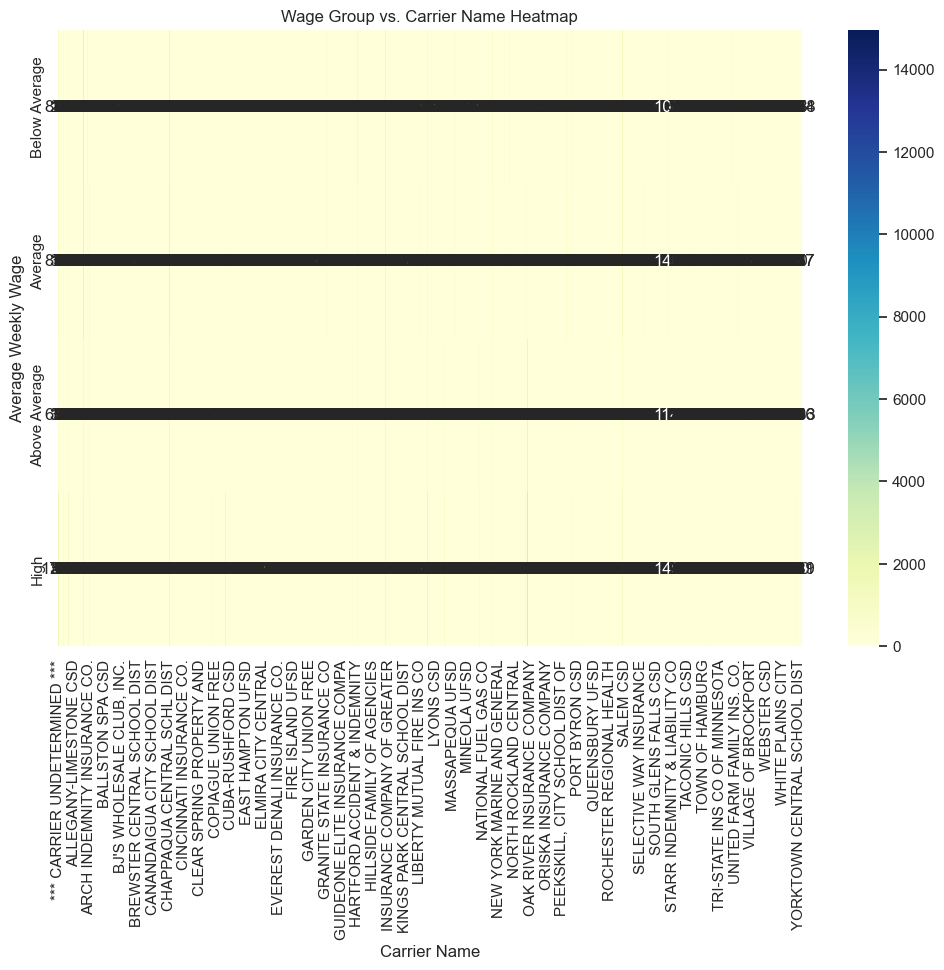

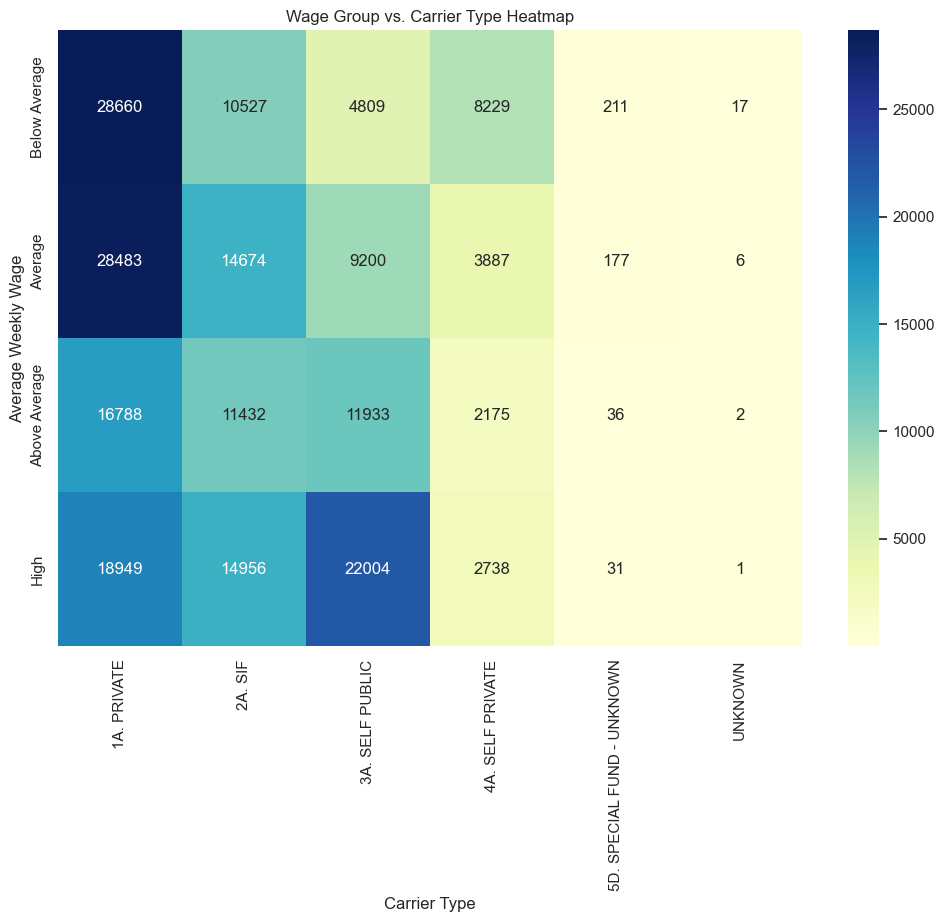

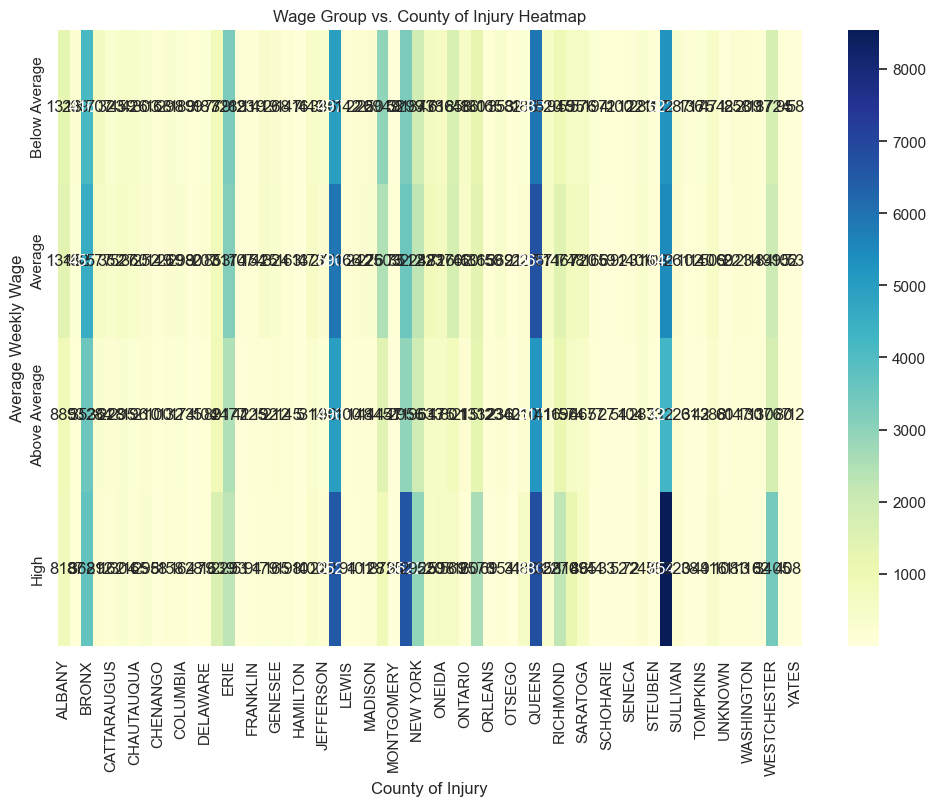

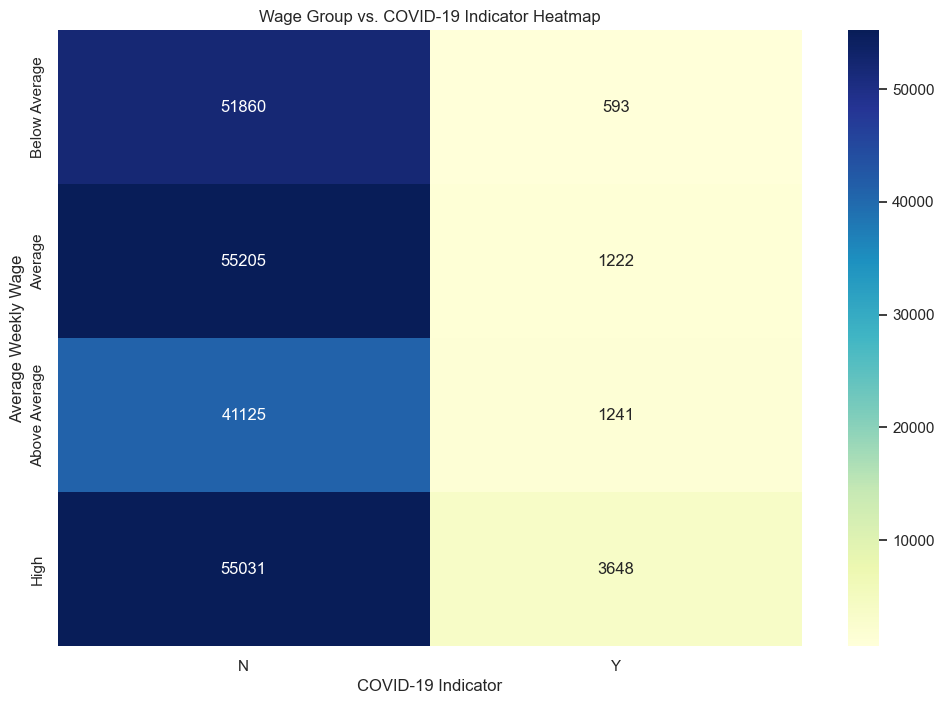

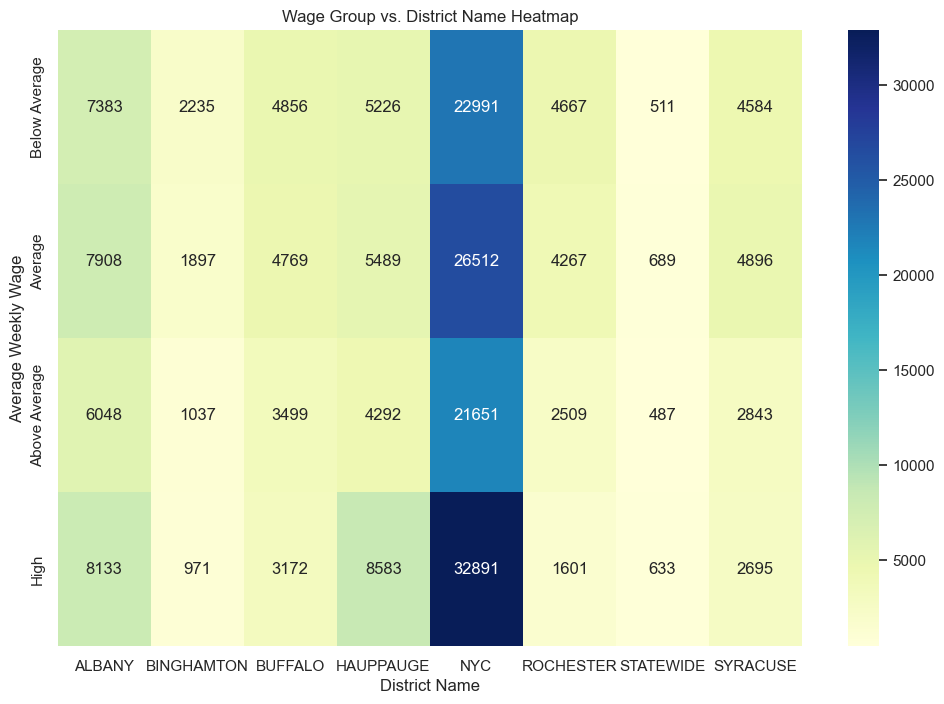

In [40]:
for feature in subset_alex_categorical:
    # Create crosstab between 'Age_Group' and the current categorical feature
    average_weekly_wage_crosstab = pd.crosstab(non_zero_wage_df['Wage_Group'], copy_train_df[feature])
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(average_weekly_wage_crosstab, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel(feature)
    plt.ylabel("Average Weekly Wage")
    plt.title(f"Wage Group vs. {feature} Heatmap")
    plt.show()

* Atorneys vs Carrier Name

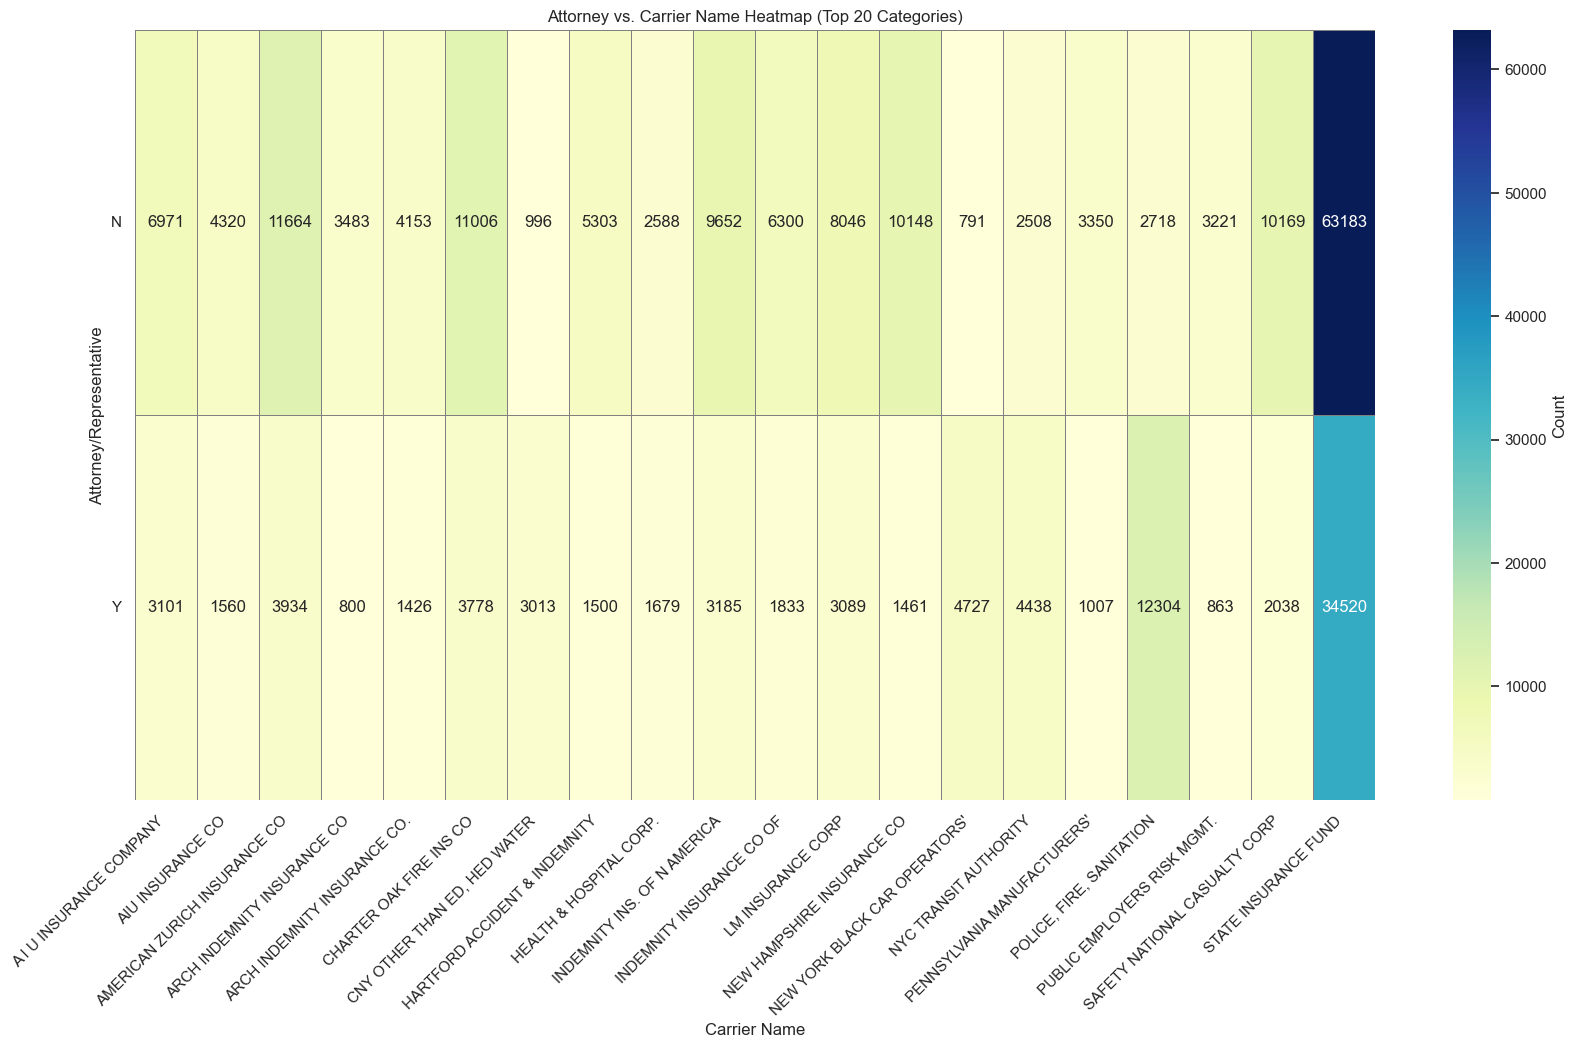

In [71]:
# Limit to top 20 attorneys and top 20 carriers by count for better readability
top_attorneys = copy_train_df['Attorney/Representative'].value_counts().nlargest(20).index
top_carriers = copy_train_df['Carrier Name'].value_counts().nlargest(20).index

filtered_data = copy_train_df[
    copy_train_df['Attorney/Representative'].isin(top_attorneys) & 
    copy_train_df['Carrier Name'].isin(top_carriers)
]

# Create a crosstab for the filtered data
crosstab_attorney_carrier = pd.crosstab(
    filtered_data['Attorney/Representative'], filtered_data['Carrier Name']
)

# Plot heatmap with adjustments
plt.figure(figsize=(20, 10))  # Increase figure size
sns.heatmap(crosstab_attorney_carrier, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='gray')  # Add gridlines for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("Carrier Name")
plt.ylabel("Attorney/Representative")
plt.title("Attorney vs. Carrier Name Heatmap (Top 20 Categories)")
plt.show()

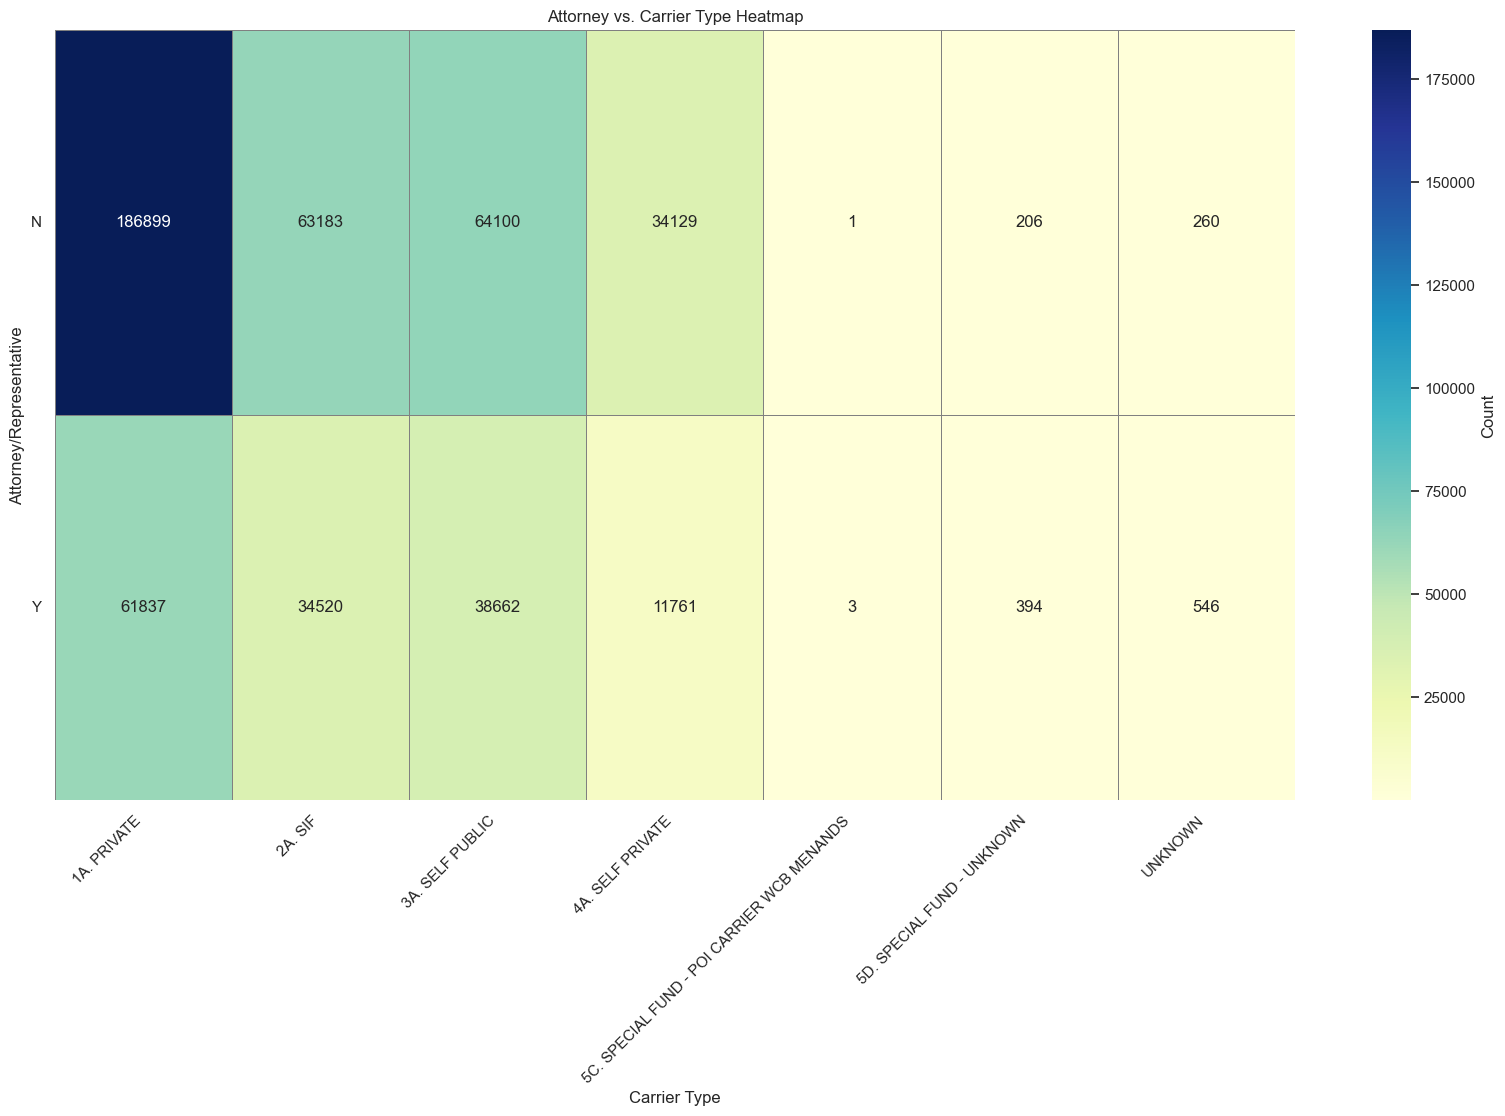

In [75]:
# Cross tabulation between 'Attorney/ Representative' and 'Carrier Type'
crosstab_attorney_carrier_type = pd.crosstab(copy_train_df['Attorney/Representative'], copy_train_df['Carrier Type'])


# Plot heatmap with adjustments
plt.figure(figsize=(20, 10))  # Increase figure size
sns.heatmap(crosstab_attorney_carrier_type, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='gray')  # Add gridlines for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("Carrier Type")
plt.ylabel("Attorney/Representative")
plt.title("Attorney vs. Carrier Type Heatmap")
plt.show()

In [66]:
# Cross tabulation between 'Attorney/ Representative' and 'District Name'
crosstab_attorney_district = pd.crosstab(copy_train_df['Attorney/Representative'], copy_train_df['District Name'])

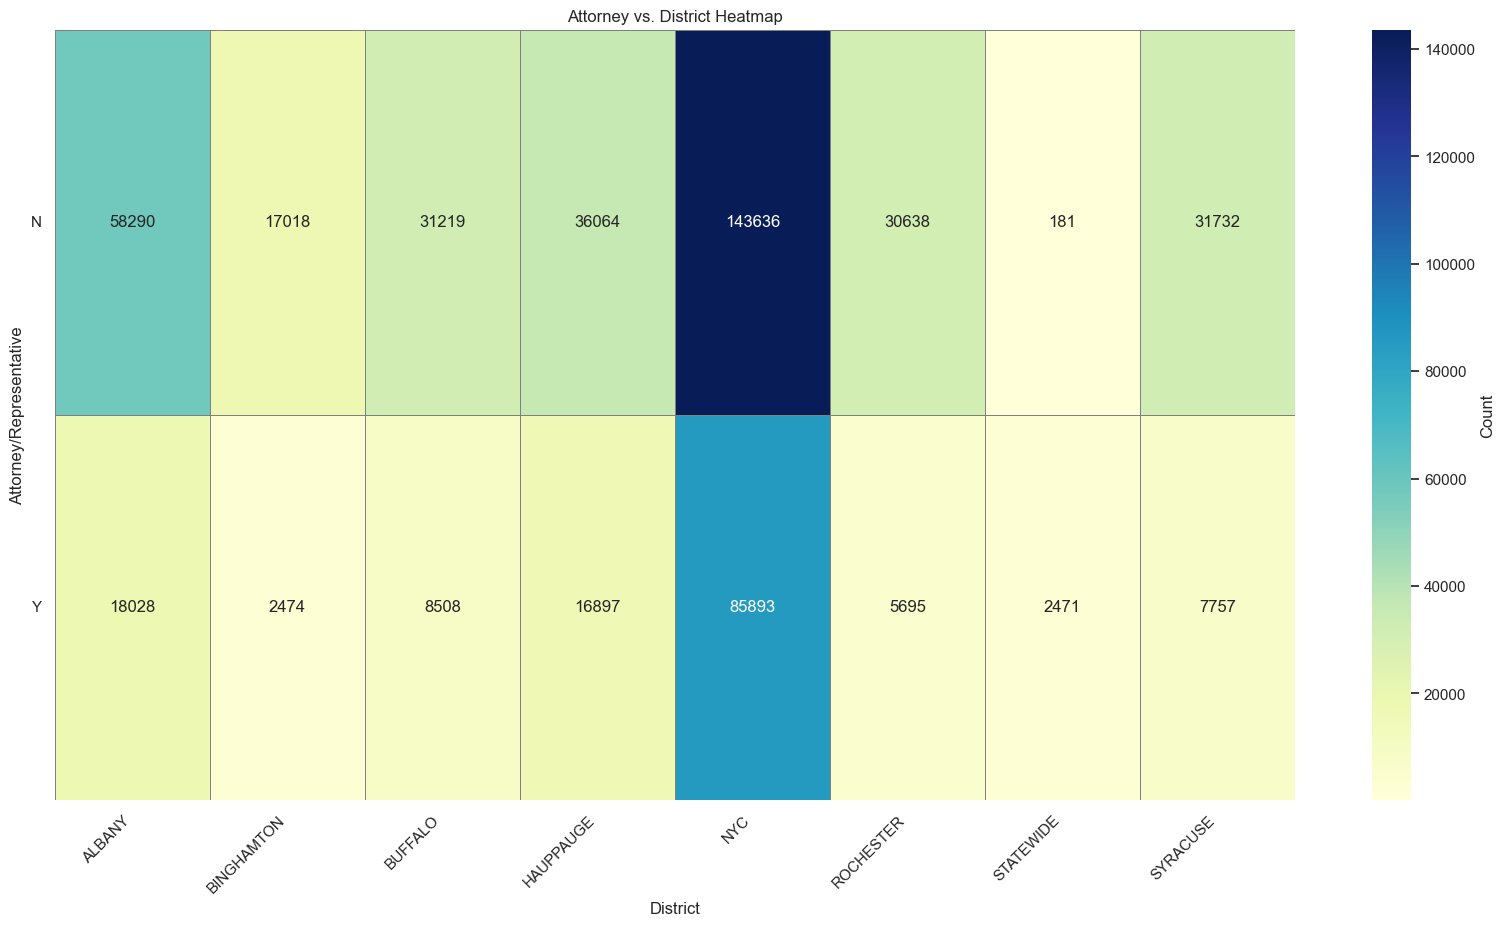

In [74]:
# Plot heatmap with adjustments
plt.figure(figsize=(20, 10))  # Increase figure size
sns.heatmap(crosstab_attorney_district, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'}, 
            linewidths=0.5, linecolor='gray')  # Add gridlines for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.xlabel("District")
plt.ylabel("Attorney/Representative")
plt.title("Attorney vs. District Heatmap")
plt.show()

#### Birth Year

In [27]:
# This variable is not relevant for the analysis, because we already have the Age at Injury variable , which is more informative , so no analysis will be done here
# Probably should be droped 

#### Claim identifier


In [28]:
# This is a unique identifier for each claim, so it is not relevant for the analysis, so no analysis will be done here

### Anomalies detection on categorical features

In [29]:
alex_categorical

['Accident Date',
 'Alternative Dispute Resolution',
 'Assembly Date',
 'Attorney/Representative',
 'C-2 Date',
 'C-3 Date',
 'Carrier Name',
 'Carrier Type',
 'County of Injury',
 'COVID-19 Indicator',
 'District Name']

In [30]:
copy_train_df['Accident Date'].isnull().sum() #3689 missing values

copy_train_df['Accident Date'].value_counts() # This variable is a bit redudant with the Age at Injury variable, so it will probably be dropped from the analysis

Accident Date
2020-03-01    1245
2020-12-18    1001
2022-02-07     977
2022-01-05     883
2021-02-18     851
              ... 
2017-05-17       1
2015-05-28       1
2002-08-18       1
2017-09-01       1
1980-05-17       1
Name: count, Length: 5539, dtype: int64

In [31]:
copy_train_df['Assembly Date'].isnull().sum()

0

In [32]:
copy_train_df['Assembly Date'].value_counts()

Assembly Date
2020-03-06    1413
2021-05-11    1370
2022-04-01    1233
2022-02-04    1194
2022-08-15    1151
              ... 
2020-12-05       1
2020-12-12       1
2021-03-20       1
2021-01-09       1
2020-09-05       1
Name: count, Length: 897, dtype: int64

In [44]:
# Convert 'Assembly Date' and 'Accident Date' columns to datetime
copy_train_df['Assembly Date'] = pd.to_datetime(copy_train_df['Assembly Date'], errors='coerce')
copy_train_df['Accident Date'] = pd.to_datetime(copy_train_df['Accident Date'], errors='coerce')

# Lag Time: Number of days between the injury date and the assembly date. This "lag time" could be a useful feature, as shorter lags might indeed correlate with more urgent or 
# severe cases.
copy_train_df['Lag_Time'] = (copy_train_df['Assembly Date'] - copy_train_df['Accident Date']).dt.days


In [34]:
print(copy_train_df['Lag_Time'].describe())

count    570337.000000
mean         82.227483
std         603.986690
min       -1127.000000
25%           5.000000
50%          10.000000
75%          24.000000
max       21503.000000
Name: Lag_Time, dtype: float64


<Axes: title={'center': 'Lag Time Boxplot'}>

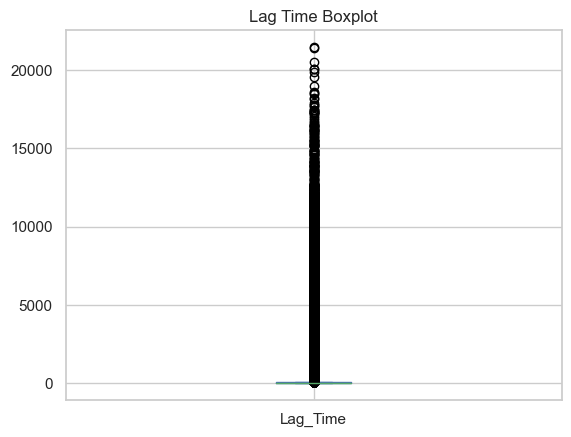

In [48]:
copy_train_df['Lag_Time'].plot.box(title='Lag Time Boxplot')

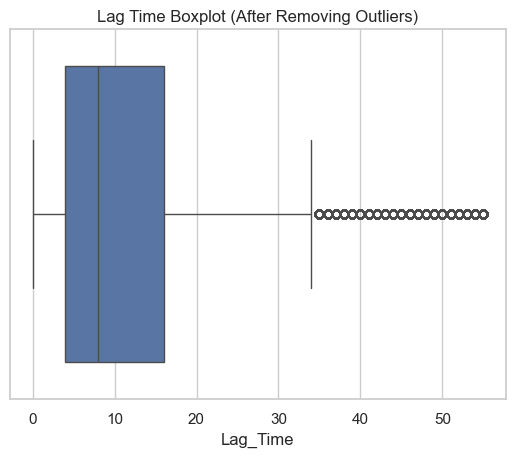

In [49]:
Q1 = copy_train_df['Lag_Time'].quantile(0.25)
Q3 = copy_train_df['Lag_Time'].quantile(0.75)
IQR = Q3 - Q1
copy_train_df = copy_train_df[(copy_train_df['Lag_Time'] >= (Q1 - 1.5 * IQR)) & 
                            (copy_train_df['Lag_Time'] <= (Q3 + 1.5 * IQR))]

sns.boxplot(x=copy_train_df['Lag_Time'])
plt.title("Lag Time Boxplot (After Removing Outliers)")
plt.show()


Negative values could arise if the Accident Date is later than the Assembly Date in some records, possibly due to data entry errors.



In [50]:
copy_train_df = copy_train_df[copy_train_df['Lag_Time'] >= 0]

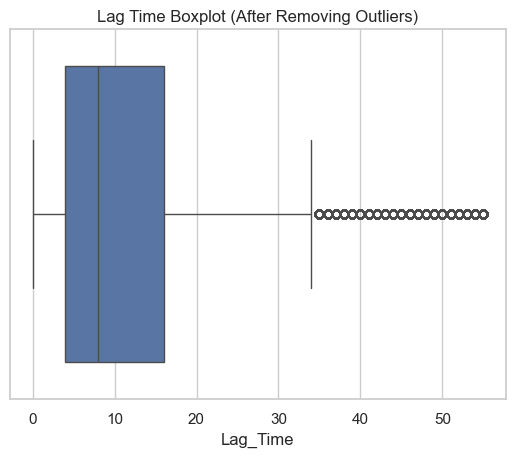

In [51]:
sns.boxplot(x=copy_train_df['Lag_Time'])
plt.title("Lag Time Boxplot (After Removing Outliers)")
plt.show()

In [53]:
# Group Lag Time into bins

# Define lag time bins and labels
lag_time_bins = [0, 7, 14, 30, 60, 90, float('inf')]
lag_time_labels = ['0-7 days', '8-14 days', '15-30 days', '31-60 days', '61-90 days', 'Above 90 days']

# Create the lag time groups
copy_train_df['Lag_Time_Group'] = pd.cut(copy_train_df['Lag_Time'], bins=lag_time_bins, labels=lag_time_labels)

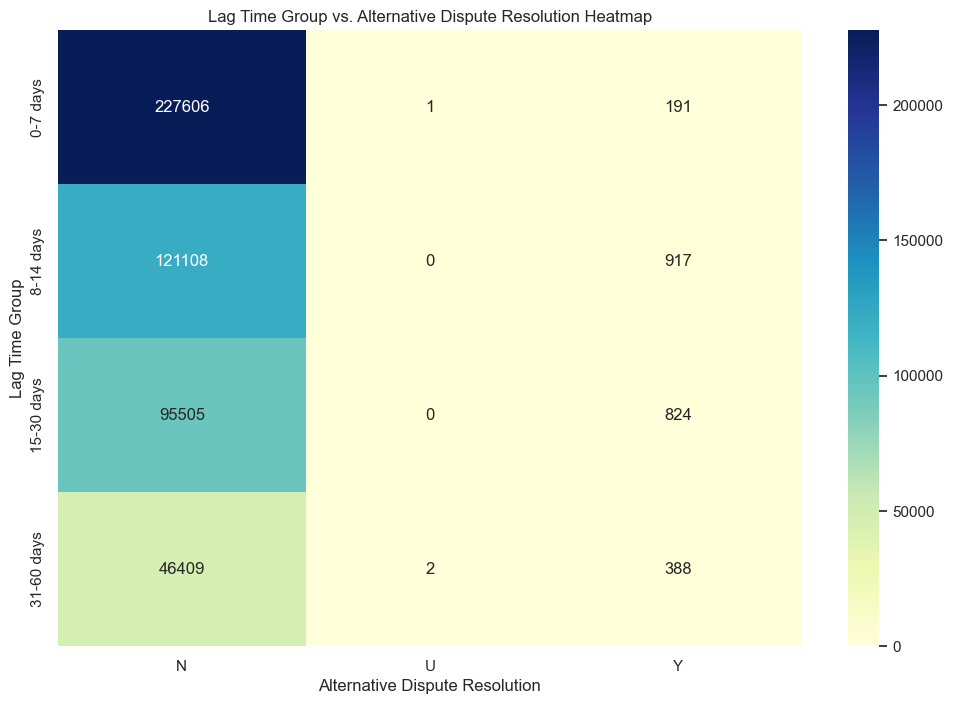

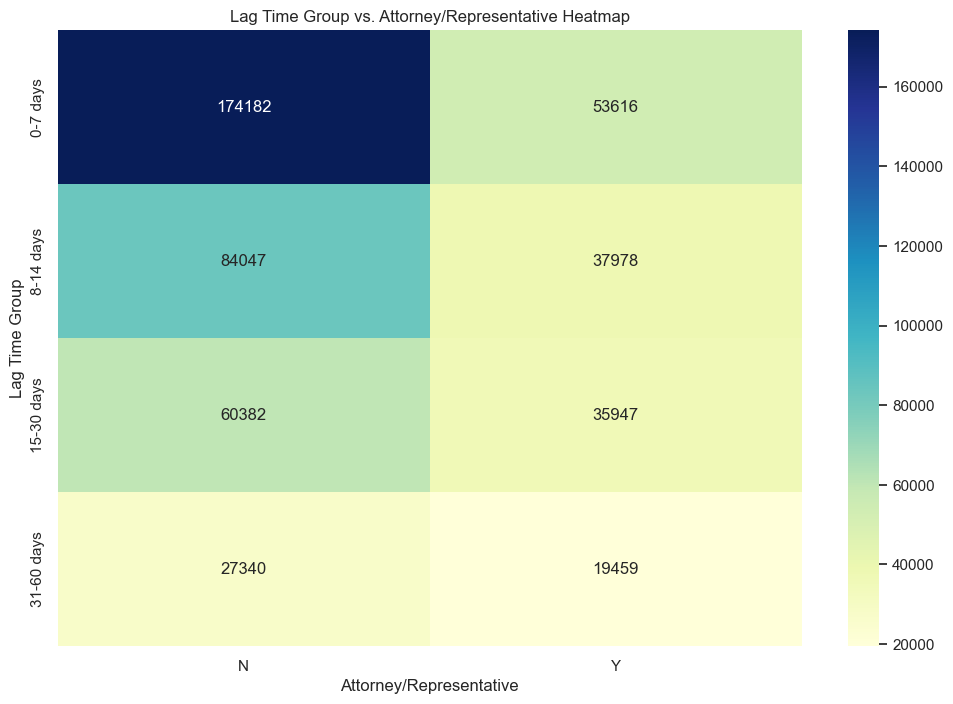

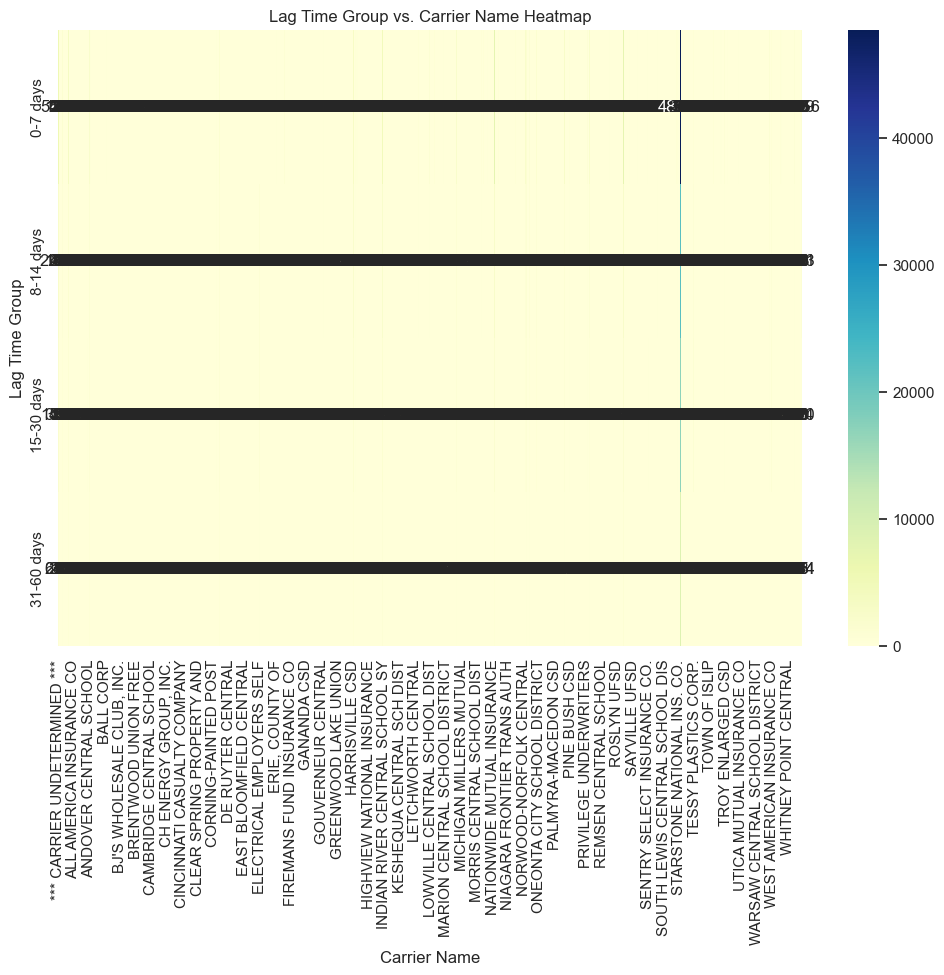

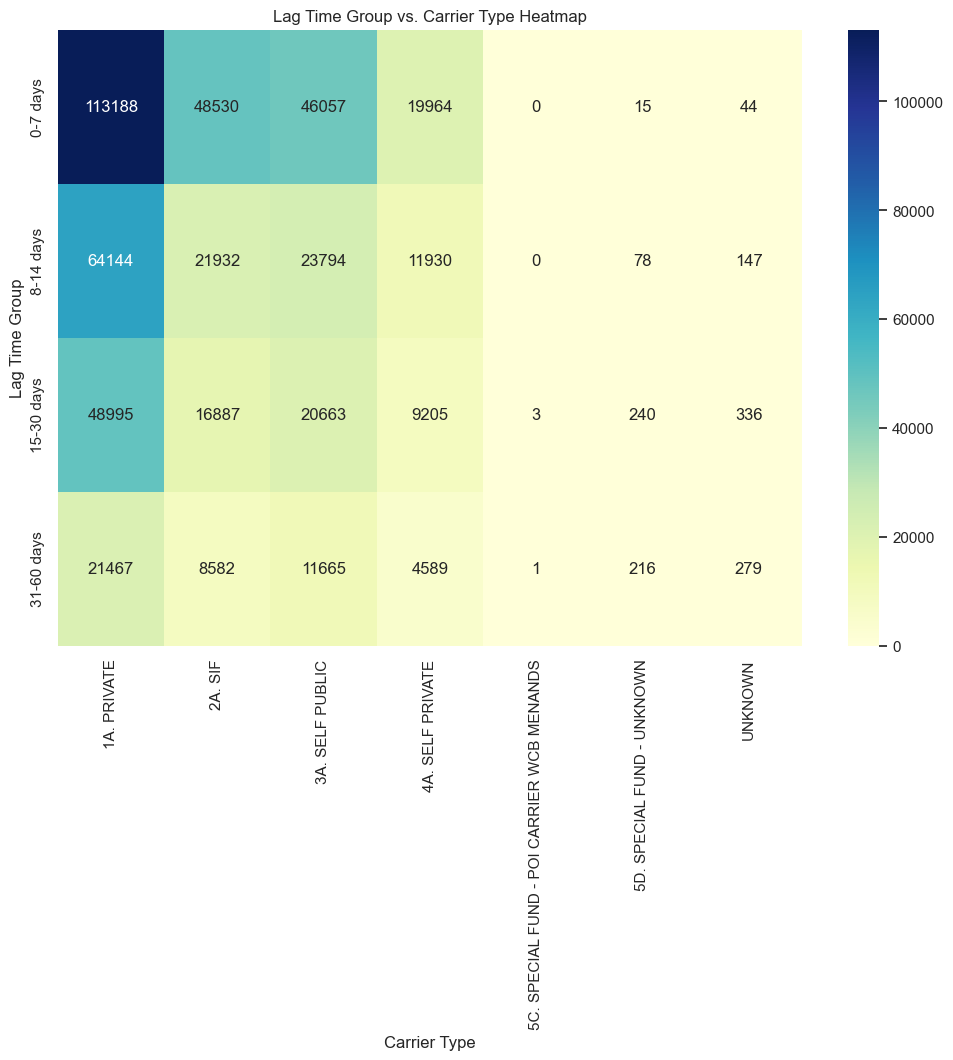

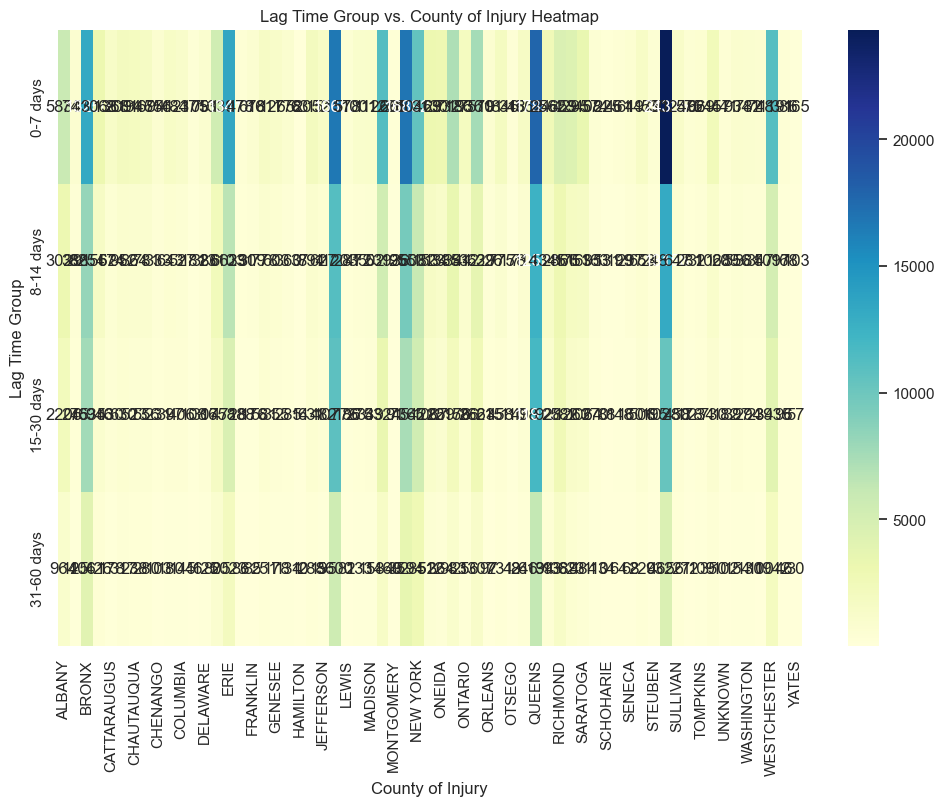

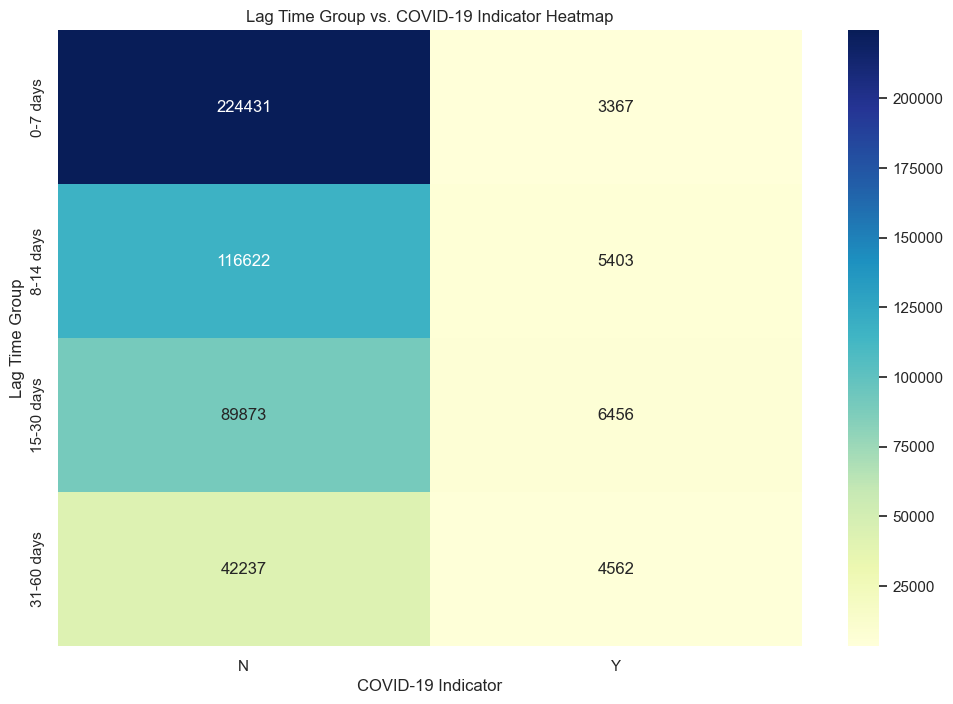

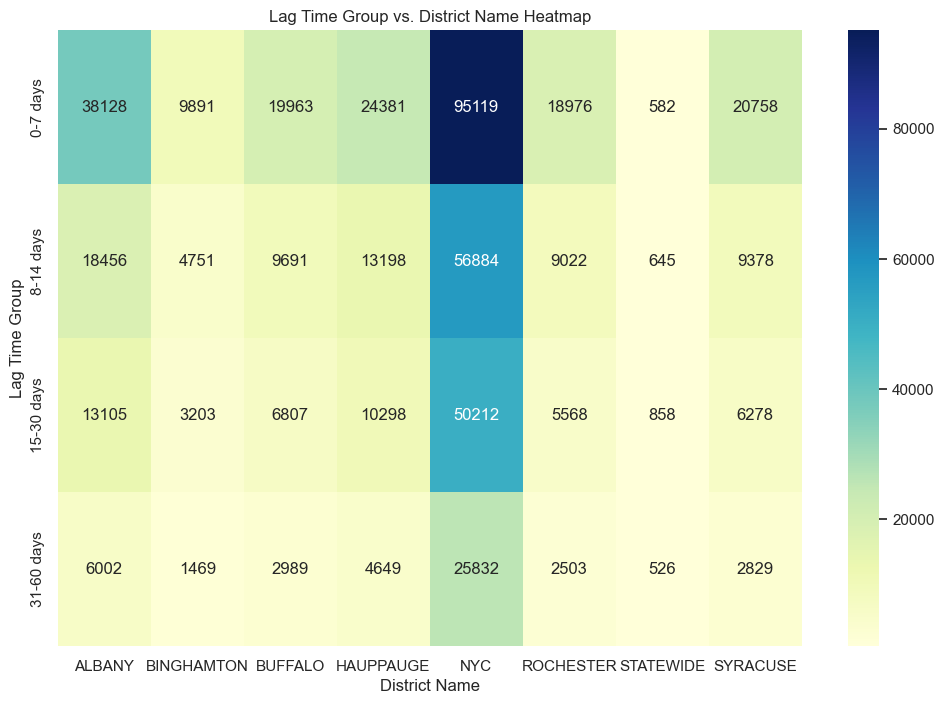

In [54]:
for feature in subset_alex_categorical:
    # Create crosstab between 'Age_Group' and the current categorical feature
    lag_time_cross_tab = pd.crosstab(copy_train_df['Lag_Time_Group'], copy_train_df[feature])
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(lag_time_cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel(feature)
    plt.ylabel("Lag Time Group")
    plt.title(f"Lag Time Group vs. {feature} Heatmap")
    plt.show()

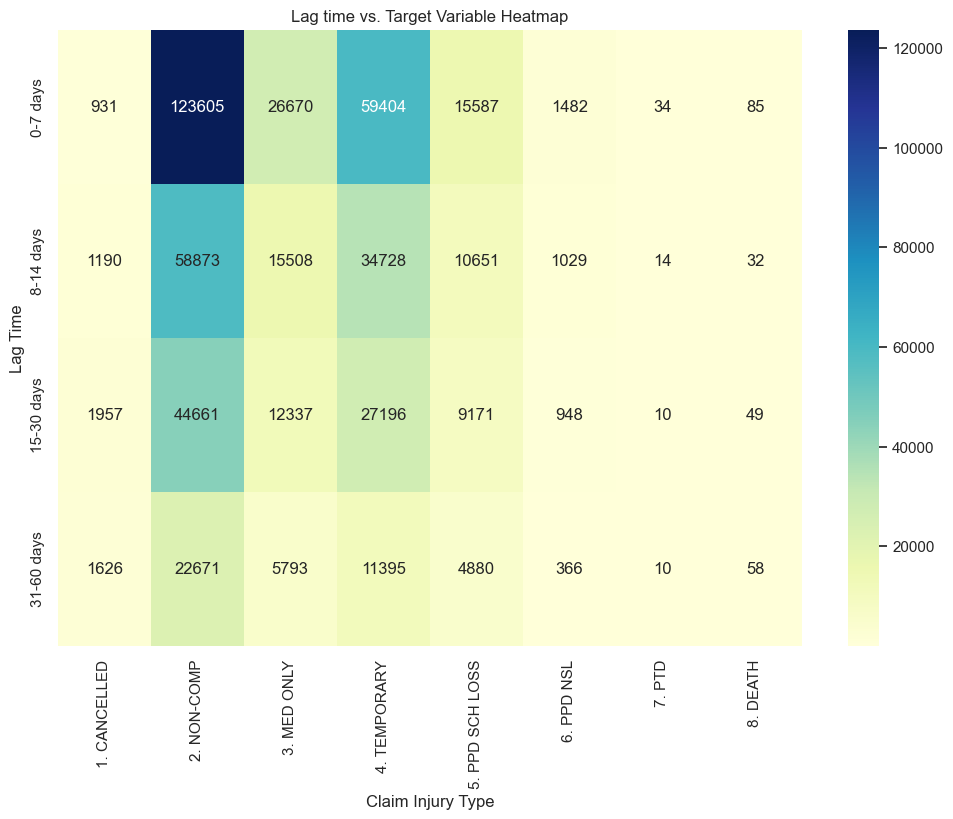

In [57]:
# Create crosstab between 'Lag Time' and the target variable

lag_time_wage_crosstab = pd.crosstab(copy_train_df['Lag_Time_Group'], copy_train_df['Claim Injury Type'])
    
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(lag_time_wage_crosstab, annot=True, fmt='d', cmap='YlGnBu')
plt.ylabel("Lag Time")
plt.title(f"Lag time vs. Target Variable Heatmap")
plt.show()

* Alternative Dispute Resolution

In [42]:
copy_train_df['Alternative Dispute Resolution'].isnull().sum() #0 Nan values

0

In [43]:
copy_train_df['Alternative Dispute Resolution'].value_counts() # 5 U values which are probably missing values

Alternative Dispute Resolution
N    571412
Y      2609
U         5
Name: count, dtype: int64

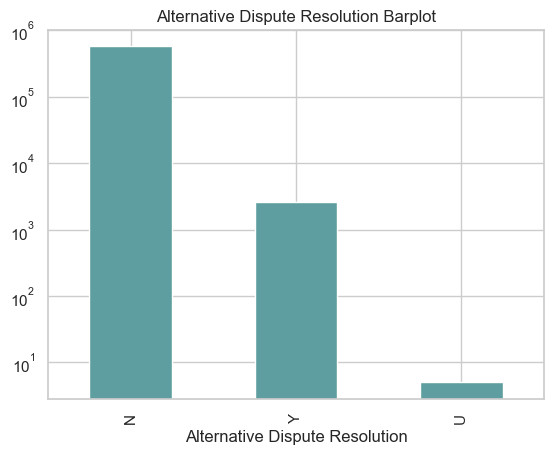

In [44]:
copy_train_df['Alternative Dispute Resolution'].value_counts().plot.bar(
    title='Alternative Dispute Resolution Barplot', color='cadetblue', logy=True
)
plt.show()


In [45]:
copy_train_df['C-2 Date'].isnull().sum() # 0 Nan values: 14560

14560

In [46]:
# Ensure that both columns are in datetime format
copy_train_df['C-2 Date'] = pd.to_datetime(copy_train_df['C-2 Date'], errors='coerce')
copy_train_df['C-3 Date'] = pd.to_datetime(copy_train_df['C-3 Date'], errors='coerce')

# New feature: Accident_to_C2_Lag -> This represents how quickly the employer reported the injury. A shorter lag may indicate a more serious injury that the employer 
# wanted to address promptly, while longer lags could suggest less urgent cases or potential administrative delays
copy_train_df['Accident_to_C2_Lag'] = (copy_train_df['C-2 Date'] - copy_train_df['Accident Date']).dt.days


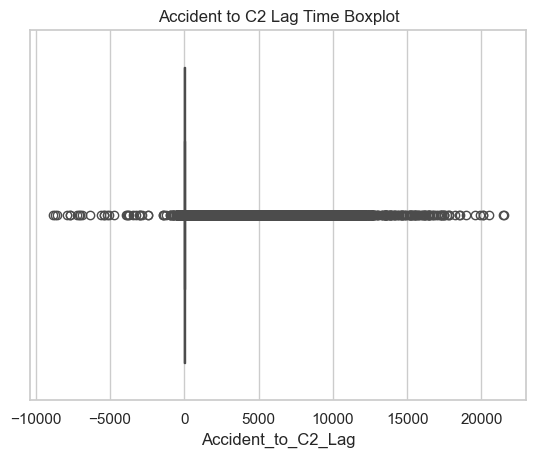

In [47]:
sns.boxplot(x=copy_train_df['Accident_to_C2_Lag'])
plt.title("Accident to C2 Lag Time Boxplot")
plt.show()



In [48]:
# The box plot shows Accident_to_C2_Lag with many extreme values, including negative values, which indicate that the C-2 Date (employer report date) is sometimes recorded as 
# earlier than the Accident Date. This may be due to data entry errors, adjustments to dates, or cases where the accident date was recorded after the employer reported the incident

In [49]:
copy_train_df = copy_train_df[copy_train_df['Accident_to_C2_Lag'] >= 0]

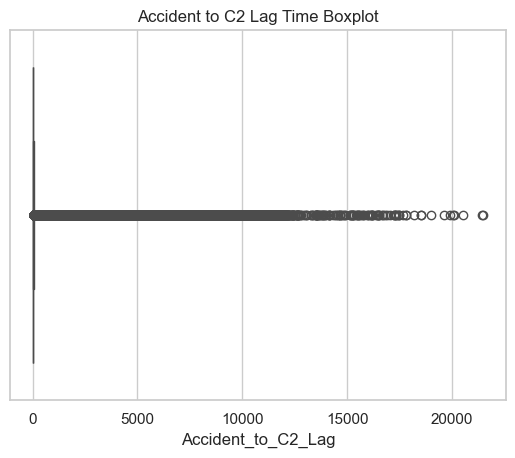

In [50]:
sns.boxplot(x=copy_train_df['Accident_to_C2_Lag'])
plt.title("Accident to C2 Lag Time Boxplot")
plt.show()


In [51]:
upper_cap = 365 * 2  # Example cap at 2 years (730 days)
copy_train_df['Accident_to_C2_Lag_Capped'] = np.where(
    copy_train_df['Accident_to_C2_Lag'] > upper_cap,
    upper_cap,
    copy_train_df['Accident_to_C2_Lag']
)

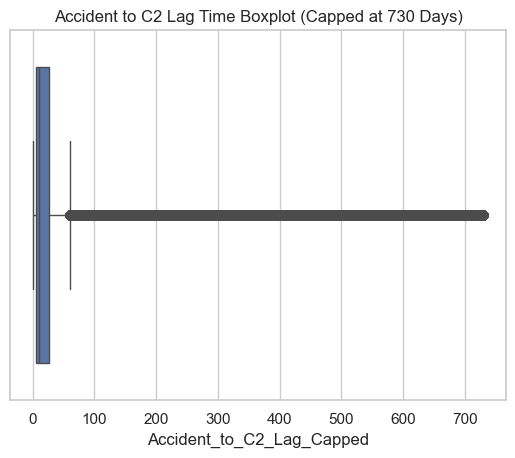

In [52]:
sns.boxplot(x=copy_train_df['Accident_to_C2_Lag_Capped'])
plt.title("Accident to C2 Lag Time Boxplot (Capped at 730 Days)")
plt.show()

In [53]:
copy_train_df['Accident_to_C2_Lag_Capped'].value_counts()

Accident_to_C2_Lag_Capped
2.0      35481
4.0      35349
3.0      34484
5.0      34397
6.0      33973
         ...  
660.0        4
650.0        4
635.0        3
718.0        3
713.0        3
Name: count, Length: 731, dtype: int64

In [71]:
# A large C3_to_C2_Lag, either positive or negative, might point to a lack of coordination. This could affect claim processing and could be a factor in predicting certain outcomes.
copy_train_df['C3_to_C2_Lag'] = (copy_train_df['C-2 Date'] - copy_train_df['C-3 Date']).dt.days

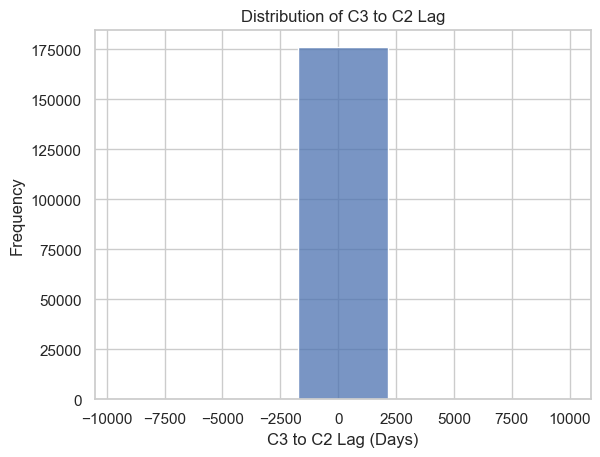

In [73]:
sns.histplot(copy_train_df['C3_to_C2_Lag'], bins=5)
plt.title("Distribution of C3 to C2 Lag")
plt.xlabel("C3 to C2 Lag (Days)")
plt.ylabel("Frequency")
plt.show()


If the C3 Date is earlier than the C2 Date, it means the employee reported the injury before the employer. A negative lag here could indicate potential delays or negligence on the employer's part, which might correlate with disputed claims or cases with outcomes like CANCELLED or NON-COMP

f the C3 Date is later than the C2 Date, it means the employee reported the injury after the employer, which could indicate proactive employer reporting. This might be common in severe cases where employers take immediate action before the employee files.

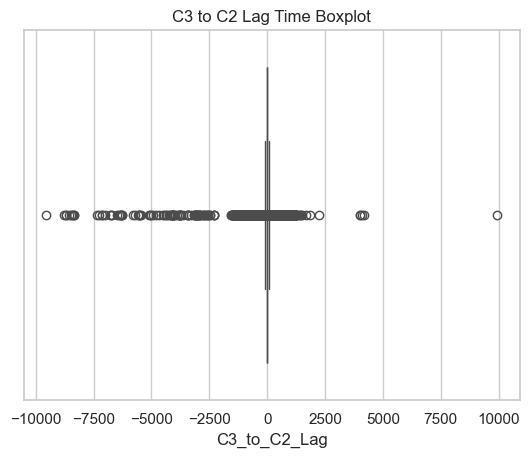

In [74]:
sns.boxplot(x=copy_train_df['C3_to_C2_Lag'])
plt.title("C3 to C2 Lag Time Boxplot")
plt.show()

In [75]:
cap_value = 365  # Cap at ±365 days
copy_train_df['C3_to_C2_Lag_Capped'] = np.where(
    copy_train_df['C3_to_C2_Lag'] > cap_value, cap_value,
    np.where(copy_train_df['C3_to_C2_Lag'] < -cap_value, -cap_value, copy_train_df['C3_to_C2_Lag'])
)


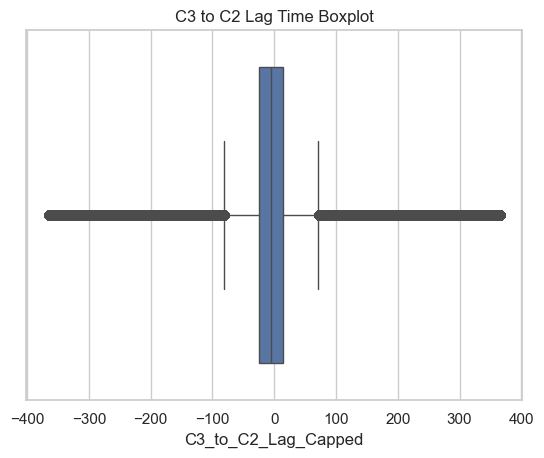

In [77]:
sns.boxplot(x=copy_train_df['C3_to_C2_Lag_Capped'])
plt.title("C3 to C2 Lag Time Boxplot")
plt.show()

### Column Types
Let's look at the number of columns of each data type. int64 and float64 are numeric variables (which can be either discrete or continuous). object columns contain strings and are categorical features. .

In [11]:
copy_train_df.dtypes.value_counts()

object     21
float64    11
int64       2
Name: count, dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [14]:
copy_train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0) # axis = 0 to apply function to each column

Accident Date                         5539
Alternative Dispute Resolution           3
Assembly Date                         1096
Attorney/Representative                  2
C-2 Date                              2475
C-3 Date                              1648
Carrier Name                          2046
Carrier Type                             8
Claim Injury Type                        9
County of Injury                        63
COVID-19 Indicator                       2
District Name                            8
First Hearing Date                    1094
Gender                                   4
Industry Code Description               20
Medical Fee Region                       5
WCIO Cause of Injury Description        74
WCIO Nature of Injury Description       56
WCIO Part Of Body Description           54
Zip Code                             10060
WCB Decision                             1
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables.

_"Explore data visually and extract relevant insights. Explain your rationale and
findings. Do not forget to analyse multivariate relationships."_

## 3. Data Cleaning and Pre-processing <a id='dataclean'></a>
[to the top](#top)

- _"Are there any missing values? Take action to handle them._
- _Check the dataset for outliers and pre-process them. Justify your decisions._
- _Deal with categorical variables._
- _Review current features and create extra features if needed. Explain your steps._
- _Perform data scaling. Explain the reasoning behind your choices."_

## 4. Feature Selection <a id='features'></a>
[to the top](#top)

_"Define and implement an unambiguous strategy for feature selection. Use methods discussed in the course. Present and justify your final selection."_

## 5. Modeling and Evaluation <a id='modeling'></a>
[to the top](#top)

- _"Identify the type of the problem and select the relevant algorithms._
- _Use cross-validation to assess performance. Which metrics did you use and why?_
- _Train at least 1 model using the train dataset and obtain predictions for the test dataset."_